## 1.0 Libraries Loading

In [1]:
# Ignore warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Scikit-learn: model selection, modeling, evaluation, calibration
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_fscore_support, roc_curve, auc
)

# Imbalanced-learn: resampling techniques
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks

# Scipy: distributions for randomized search
from scipy.stats import uniform, randint

# SHAP: explainability
import shap

# Joblib: model persistence
import joblib

c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.0 Data Loading

In [2]:
# Load data
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [3]:
# Basic info
print("Dataset Shape (Rows, Columns):", df.shape)
print("Column Names:\n", df.columns.tolist())

Dataset Shape (Rows, Columns): (7043, 21)
Column Names:
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [4]:
# Peek at the data
print("First 5 Rows:")
print(df.head())

First 5 Rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies       

In [5]:
# Data types
print("Data Types:\n", df.dtypes)

Data Types:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [6]:
# Missing values
print("Missing Values Per Column:\n", df.isnull().sum())

Missing Values Per Column:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


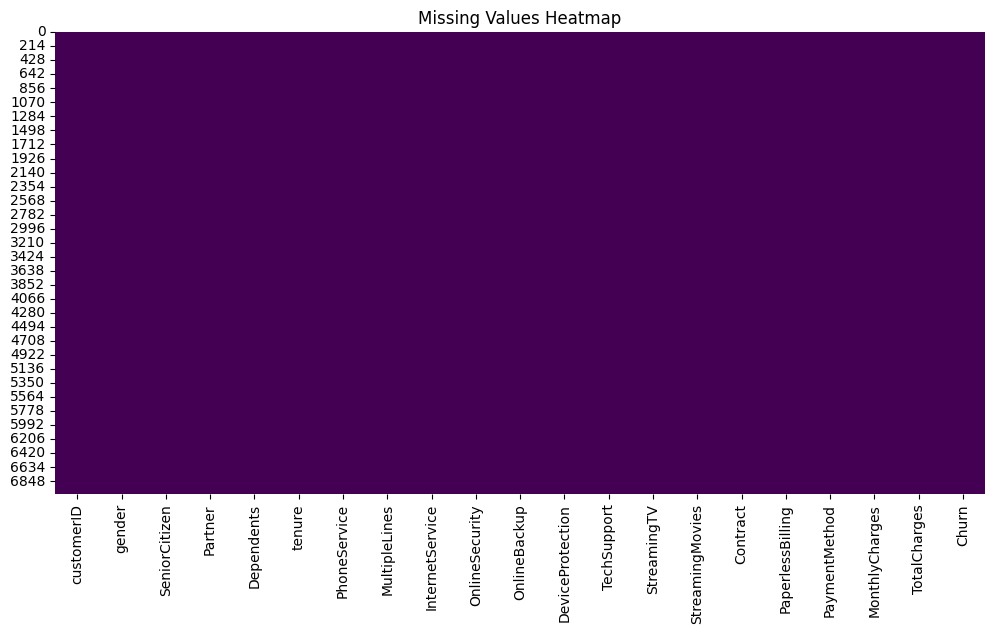

In [7]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

In [8]:
# Unique value counts for each column
print("Unique Values Per Column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

Unique Values Per Column:
customerID: 7043 unique values
gender: 2 unique values
SeniorCitizen: 2 unique values
Partner: 2 unique values
Dependents: 2 unique values
tenure: 73 unique values
PhoneService: 2 unique values
MultipleLines: 3 unique values
InternetService: 3 unique values
OnlineSecurity: 3 unique values
OnlineBackup: 3 unique values
DeviceProtection: 3 unique values
TechSupport: 3 unique values
StreamingTV: 3 unique values
StreamingMovies: 3 unique values
Contract: 3 unique values
PaperlessBilling: 2 unique values
PaymentMethod: 4 unique values
MonthlyCharges: 1585 unique values
TotalCharges: 6531 unique values
Churn: 2 unique values


In [9]:
# Class distribution for the target variable (if already known)
if 'Churn' in df.columns:
    print("Target Variable ('Churn') Distribution:")
    print(df['Churn'].value_counts(normalize=True).round(3))

Target Variable ('Churn') Distribution:
Churn
No     0.735
Yes    0.265
Name: proportion, dtype: float64


## 3.0 Data Cleaning

In [10]:
# Copy the original DataFrame for auditing
df_clean = df.copy()

In [11]:
# Convert 'TotalCharges' to numeric
print("Converting 'TotalCharges' to numeric...")

Converting 'TotalCharges' to numeric...


In [12]:
# Check how many non-numeric entries exist before conversion
non_numeric_total_charges = df_clean['TotalCharges'].apply(lambda x: not str(x).replace('.', '', 1).isdigit()).sum()
print(f"Non-numeric 'TotalCharges' entries before conversion: {non_numeric_total_charges}")

df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')

Non-numeric 'TotalCharges' entries before conversion: 11


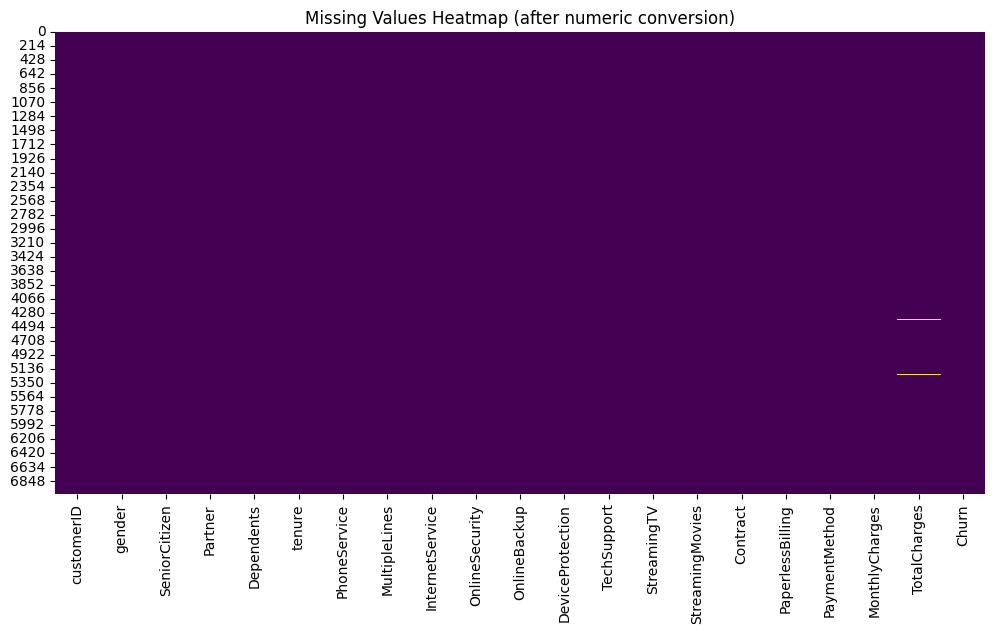

In [13]:
plt.figure(figsize=(12, 6))
sns.heatmap(df_clean.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap (after numeric conversion)")
plt.show()

In [14]:
# Check why TotalCharges is object
print("Unique problematic values in TotalCharges:")
print(df.loc[df['TotalCharges'].str.strip() == '', 'TotalCharges'])

Unique problematic values in TotalCharges:
488      
753      
936      
1082     
1340     
3331     
3826     
4380     
5218     
6670     
6754     
Name: TotalCharges, dtype: object


In [15]:
# Drop rows with missing 'TotalCharges'
missing_before = df_clean.shape[0]
df_clean = df_clean.dropna(subset=['TotalCharges'])
missing_after = df_clean.shape[0]
print(f"Rows dropped due to missing 'TotalCharges': {missing_before - missing_after}")

Rows dropped due to missing 'TotalCharges': 11


In [16]:
# Drop 'customerID' column 
print("Dropping 'customerID' column (high cardinality identifier)...")
df_clean.drop(columns=['customerID'], inplace=True)

Dropping 'customerID' column (high cardinality identifier)...


In [17]:
# Normalize categorical noise values
cols_to_normalize = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                     'DeviceProtection', 'TechSupport',
                     'StreamingTV', 'StreamingMovies']

print("Replacing 'No internet service' and 'No phone service' with 'No' in service columns:")
for col in cols_to_normalize:
    before_vals = df_clean[col].value_counts()
    df_clean[col] = df_clean[col].replace({'No internet service': 'No', 'No phone service': 'No'})
    after_vals = df_clean[col].value_counts()
    print(f"Column: {col}")
    print("Before:")
    print(before_vals)
    print("After:")
    print(after_vals)

Replacing 'No internet service' and 'No phone service' with 'No' in service columns:
Column: MultipleLines
Before:
MultipleLines
No                  3385
Yes                 2967
No phone service     680
Name: count, dtype: int64
After:
MultipleLines
No     4065
Yes    2967
Name: count, dtype: int64
Column: OnlineSecurity
Before:
OnlineSecurity
No                     3497
Yes                    2015
No internet service    1520
Name: count, dtype: int64
After:
OnlineSecurity
No     5017
Yes    2015
Name: count, dtype: int64
Column: OnlineBackup
Before:
OnlineBackup
No                     3087
Yes                    2425
No internet service    1520
Name: count, dtype: int64
After:
OnlineBackup
No     4607
Yes    2425
Name: count, dtype: int64
Column: DeviceProtection
Before:
DeviceProtection
No                     3094
Yes                    2418
No internet service    1520
Name: count, dtype: int64
After:
DeviceProtection
No     4614
Yes    2418
Name: count, dtype: int64
Column: TechSup

In [18]:
# Final check
print("Final Shape After Cleaning:", df_clean.shape)
print("Any remaining missing values?")
print(df_clean.isnull().sum())

Final Shape After Cleaning: (7032, 20)
Any remaining missing values?
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


## 4.0 Feature Engineering

In [19]:
# Copy the cleaned dataset
df_fe = df_clean.copy()

In [20]:
# Encode target variable
print("Encoding target variable 'Churn' to binary (Yes=1, No=0)...")
df_fe['Churn'] = df_fe['Churn'].map({'No': 0, 'Yes': 1})
print("Class distribution after encoding:")
print(df_fe['Churn'].value_counts(normalize=True).round(3))

Encoding target variable 'Churn' to binary (Yes=1, No=0)...
Class distribution after encoding:
Churn
0    0.734
1    0.266
Name: proportion, dtype: float64


In [21]:
# One-hot encode categorical features
print("Performing one-hot encoding on categorical features...")
df_fe_encoded = pd.get_dummies(df_fe, drop_first=True)
print("One-hot encoding completed.")
print(f"Shape after encoding: {df_fe_encoded.shape}")
print("New columns created:")
print(set(df_fe_encoded.columns) - set(df_fe.columns))

Performing one-hot encoding on categorical features...
One-hot encoding completed.
Shape after encoding: (7032, 24)
New columns created:
{'StreamingTV_Yes', 'PaperlessBilling_Yes', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'TechSupport_Yes', 'Partner_Yes', 'Dependents_Yes', 'gender_Male', 'OnlineBackup_Yes', 'MultipleLines_Yes', 'PhoneService_Yes', 'OnlineSecurity_Yes', 'InternetService_No', 'PaymentMethod_Electronic check', 'DeviceProtection_Yes', 'PaymentMethod_Mailed check', 'Contract_One year', 'InternetService_Fiber optic', 'StreamingMovies_Yes'}


In [22]:
# Enforce fixed feature set for model compatibility
selected_features = [
    'tenure', 'MonthlyCharges', 'TotalCharges',
    'Contract_One year', 'Contract_Two year',
    'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check',
    'PaymentMethod_Mailed check',
    'InternetService_Fiber optic', 'InternetService_No',
    'OnlineSecurity_Yes', 'TechSupport_Yes', 'StreamingTV_Yes', 'PaperlessBilling_Yes'
]

In [23]:
# Rebuild X if not already defined
try:
    X
except NameError:
    df_model = df_fe_encoded[['Churn'] + selected_features]
    X = df_model.drop(columns='Churn')

# Now check types
feature_types = {feature: X[feature].dtype for feature in selected_features}

# Print in readable format
for feature, dtype in feature_types.items():
    print(f"{feature:<45} {dtype}")

tenure                                        int64
MonthlyCharges                                float64
TotalCharges                                  float64
Contract_One year                             bool
Contract_Two year                             bool
PaymentMethod_Credit card (automatic)         bool
PaymentMethod_Electronic check                bool
PaymentMethod_Mailed check                    bool
InternetService_Fiber optic                   bool
InternetService_No                            bool
OnlineSecurity_Yes                            bool
TechSupport_Yes                               bool
StreamingTV_Yes                               bool
PaperlessBilling_Yes                          bool


In [24]:
# Confirm all required features exist after encoding
missing_features = [f for f in selected_features if f not in df_fe_encoded.columns]
if missing_features:
    print(f"Missing required features after encoding: {missing_features}")
    raise ValueError("Feature mismatch. Model input structure cannot be guaranteed.")
else:
    print("All required features are present.")

All required features are present.


In [25]:
# Final dataset for modeling
df_model = df_fe_encoded[['Churn'] + selected_features]
print("Final modeling dataset shape:", df_model.shape)
print("Features used:\n", selected_features)

Final modeling dataset shape: (7032, 15)
Features used:
 ['tenure', 'MonthlyCharges', 'TotalCharges', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_Yes', 'TechSupport_Yes', 'StreamingTV_Yes', 'PaperlessBilling_Yes']


## 5.0 Train-Test Split

In [26]:
# Separate features and target
X = df_model.drop(columns='Churn')
y = df_model['Churn']

In [27]:
# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [28]:
# Diagnostics
print("Data Split Summary:")
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Data Split Summary:
Training set: (5625, 14), Test set: (1407, 14)


In [29]:
# Check class distribution
def class_balance_report(y, label):
    counts = y.value_counts()
    proportions = y.value_counts(normalize=True).round(3)
    print(f"{label} Class Distribution:")
    print(f"  0 (No Churn): {counts[0]} ({proportions[0]*100}%)")
    print(f"  1 (Churn)   : {counts[1]} ({proportions[1]*100}%)")

class_balance_report(y_train, "Training Set")
class_balance_report(y_test, "Test Set")

Training Set Class Distribution:
  0 (No Churn): 4130 (73.4%)
  1 (Churn)   : 1495 (26.6%)
Test Set Class Distribution:
  0 (No Churn): 1033 (73.4%)
  1 (Churn)   : 374 (26.6%)


## 6.0 Baseline Models

### 6.1 Unweighted Models

In [30]:
def evaluate_model(model, X_test, y_test, label=""):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"===== {label} =====")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=2))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f"ROC AUC  : {roc_auc:.4f}\n")

def check_overfitting(model, X_train, y_train, X_test, y_test, label="Model"):
    from sklearn.metrics import f1_score, roc_auc_score

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    f1_train = f1_score(y_train, y_train_pred)
    f1_test = f1_score(y_test, y_test_pred)
    auc_train = roc_auc_score(y_train, y_train_proba)
    auc_test = roc_auc_score(y_test, y_test_proba)

    print(f"{label} — Overfitting Diagnostic")
    print(f"F1 Score   → Train: {f1_train:.4f} | Test: {f1_test:.4f}")
    print(f"ROC AUC    → Train: {auc_train:.4f} | Test: {auc_test:.4f}")
    
    if abs(f1_train - f1_test) > 0.1 or abs(auc_train - auc_test) > 0.1:
        print("Potential overfitting detected.\n")
    else:
        print("No major overfitting symptoms detected.\n")


In [31]:
# Logistic Regression (Unweighted)
lr_unbalanced = LogisticRegression(max_iter=1000, random_state=42)
lr_unbalanced.fit(X_train, y_train)
evaluate_model(lr_unbalanced, X_test, y_test, "Logistic Regression (Unweighted)")
check_overfitting(lr_unbalanced, X_train, y_train, X_test, y_test, "Logistic Regression (Unweighted)")

# Random Forest (Unweighted)
rf_unbalanced = RandomForestClassifier(random_state=42)
rf_unbalanced.fit(X_train, y_train)
evaluate_model(rf_unbalanced, X_test, y_test, "Random Forest (Unweighted)")
check_overfitting(rf_unbalanced, X_train, y_train, X_test, y_test, "Random Forest (Unweighted)")

c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


===== Logistic Regression (Unweighted) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1033
           1       0.63      0.54      0.58       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407

Confusion Matrix:
[[913 120]
 [173 201]]
ROC AUC  : 0.8363

Logistic Regression (Unweighted) — Overfitting Diagnostic
F1 Score   → Train: 0.5867 | Test: 0.5784
ROC AUC    → Train: 0.8469 | Test: 0.8363
No major overfitting symptoms detected.

===== Random Forest (Unweighted) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.50      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78   

### 6.2 Weighted Models

In [32]:
# Logistic Regression (Weighted)
lr_balanced = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_balanced.fit(X_train, y_train)
evaluate_model(lr_balanced, X_test, y_test, "Logistic Regression (Weighted)")
check_overfitting(lr_balanced, X_train, y_train, X_test, y_test, "Logistic Regression (Weighted)")

# Random Forest (Weighted)
rf_balanced = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_balanced.fit(X_train, y_train)
evaluate_model(rf_balanced, X_test, y_test, "Random Forest (Weighted)")
check_overfitting(rf_balanced, X_train, y_train, X_test, y_test, "Random Forest (Weighted)")

c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


===== Logistic Regression (Weighted) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1033
           1       0.50      0.80      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.74      1407

Confusion Matrix:
[[728 305]
 [ 75 299]]
ROC AUC  : 0.8353

Logistic Regression (Weighted) — Overfitting Diagnostic
F1 Score   → Train: 0.6311 | Test: 0.6115
ROC AUC    → Train: 0.8467 | Test: 0.8353
No major overfitting symptoms detected.

===== Random Forest (Weighted) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.61      0.50      0.55       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.7

### 6.3 Overfitting Diagnostic

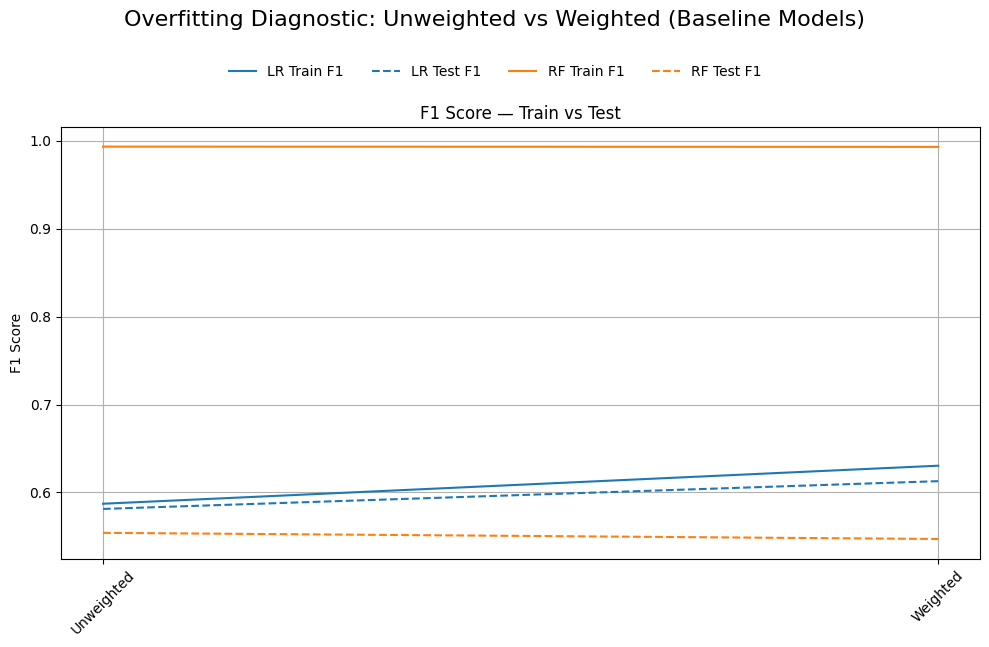

In [33]:
# Data
df_baseline = pd.DataFrame({
    "Model": ["LogReg", "LogReg", "RF", "RF"],
    "Variation": ["Unweighted", "Weighted", "Unweighted", "Weighted"],
    "F1_Train": [0.5872, 0.6305, 0.9936, 0.9933],
    "F1_Test": [0.5813, 0.6129, 0.5541, 0.5471],
    "AUC_Train": [0.8469, 0.8467, 0.9998, 0.9996],
    "AUC_Test": [0.8363, 0.8353, 0.8066, 0.8160]
})

# Split by model
logreg = df_baseline[df_baseline["Model"] == "LogReg"]
rf = df_baseline[df_baseline["Model"] == "RF"]

# Subplots side-by-side (now just one subplot)
fig, ax = plt.subplots(1, 1, figsize=(10, 6)) # Changed to 1 subplot

# Colors for F1
logreg_f1_color = '#1f77b4'   # blue
rf_f1_color = '#ff7f0e'       # orange

# F1 Score plot (axes[0] changed to ax)
ax.plot(logreg["Variation"], logreg["F1_Train"], color=logreg_f1_color, linestyle='-', label='Logistic Regression (Train F1)')
ax.plot(logreg["Variation"], logreg["F1_Test"], color=logreg_f1_color, linestyle='--', label='Logistic Regression (Test F1)')
ax.plot(rf["Variation"], rf["F1_Train"], color=rf_f1_color, linestyle='-', label='Random Forest (Train F1)')
ax.plot(rf["Variation"], rf["F1_Test"], color=rf_f1_color, linestyle='--', label='Random Forest (Test F1)')
ax.set_title('F1 Score — Train vs Test')
ax.set_ylabel('F1 Score')
ax.grid(True)
ax.tick_params(axis='x', rotation=45)

# ROC AUC plot removed

# Title and unified legend
fig.suptitle('Overfitting Diagnostic: Unweighted vs Weighted (Baseline Models)', fontsize=16, y=1.12)

legend_elements = [
    Line2D([0], [0], color=logreg_f1_color, linestyle='-', label='LR Train F1'),
    Line2D([0], [0], color=logreg_f1_color, linestyle='--', label='LR Test F1'),
    Line2D([0], [0], color=rf_f1_color, linestyle='-', label='RF Train F1'),
    Line2D([0], [0], color=rf_f1_color, linestyle='--', label='RF Test F1'),
]

fig.legend(
    handles=legend_elements,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=4,
    fontsize=10,
    frameon=False
)

# Final layout adjustments (adjusted for single subplot)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.subplots_adjust(top=0.925) # Adjusted top margin since only one plot now
plt.show() 

## 7.0 Data Resampling

### 7.1 Original Class Distribution

C:\Users\danie\AppData\Local\Temp\ipykernel_17336\1481932381.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


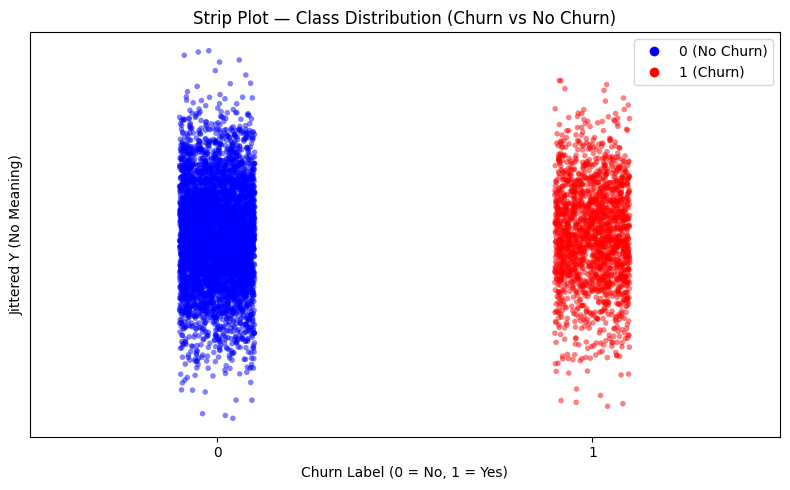

In [34]:
# Convert Churn to string labels for compatibility with palette
df['Churn_binary'] = df['Churn'].map({'No': '0', 'Yes': '1'})  # or .astype(str)

# Strip Plot
plt.figure(figsize=(8, 5))
sns.stripplot(
    x='Churn_binary',
    y=np.random.normal(0, 0.1, size=len(df)),  # jittered y-axis
    data=df,
    palette={'0': 'blue', '1': 'red'},
    alpha=0.5,
    size=4
)

# Legend
plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='0 (No Churn)', markerfacecolor='blue', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='1 (Churn)', markerfacecolor='red', markersize=8)
    ],
    loc='upper right'
)

# Style
plt.title("Strip Plot — Class Distribution (Churn vs No Churn)")
plt.xlabel("Churn Label (0 = No, 1 = Yes)")
plt.ylabel("Jittered Y (No Meaning)")
plt.yticks([])
plt.tight_layout()
plt.show()

### 7.2 Oversampling with ADASYN

In [35]:
# Original class distribution
print("Original Training Set Class Distribution:")
print(y_train.value_counts())
print("Shape before ADASYN:", X_train.shape)

# Apply ADASYN
adasyn = ADASYN(random_state=42)
X_train_ada, y_train_ada = adasyn.fit_resample(X_train, y_train)

# Resampled class distribution
print("\nAfter ADASYN Resampling:")
print(pd.Series(y_train_ada).value_counts())
print("Shape after ADASYN:", X_train_ada.shape)

Original Training Set Class Distribution:
Churn
0    4130
1    1495
Name: count, dtype: int64
Shape before ADASYN: (5625, 14)

After ADASYN Resampling:
Churn
1    4197
0    4130
Name: count, dtype: int64
Shape after ADASYN: (8327, 14)


### 7.3 Undersampling with Tomek Links

In [36]:
# Original class distribution
print("Original Training Set Class Distribution:")
print(y_train.value_counts())
print("Shape before Tomek Links:", X_train.shape)

# Apply Tomek Links
tomek = TomekLinks()
X_train_tomek, y_train_tomek = tomek.fit_resample(X_train, y_train)

# Resampled class distribution
print("\nAfter Tomek Links Resampling:")
print(pd.Series(y_train_tomek).value_counts())
print("Shape after Tomek Links:", X_train_tomek.shape)

Original Training Set Class Distribution:
Churn
0    4130
1    1495
Name: count, dtype: int64
Shape before Tomek Links: (5625, 14)

After Tomek Links Resampling:
Churn
0    3681
1    1495
Name: count, dtype: int64
Shape after Tomek Links: (5176, 14)


### 7.3 Hybrid sampling with ADASYN + Tomek Links

In [37]:
# Step 1: ADASYN oversampling
print("\nApplying ADASYN first...")
adasyn = ADASYN(random_state=42)
X_ada, y_ada = adasyn.fit_resample(X_train, y_train)
print("After ADASYN:")
print(pd.Series(y_ada).value_counts())
print("Shape:", X_ada.shape)

# Step 2: Tomek cleaning
print("\nApplying Tomek Links on ADASYN output...")
tomek = TomekLinks()
X_ada_tomek, y_ada_tomek = tomek.fit_resample(X_ada, y_ada)
print("After Tomek on ADASYN:")
print(pd.Series(y_ada_tomek).value_counts())
print("Shape:", X_ada_tomek.shape)


Applying ADASYN first...
After ADASYN:
Churn
1    4197
0    4130
Name: count, dtype: int64
Shape: (8327, 14)

Applying Tomek Links on ADASYN output...
After Tomek on ADASYN:
Churn
0    4130
1    3759
Name: count, dtype: int64
Shape: (7889, 14)


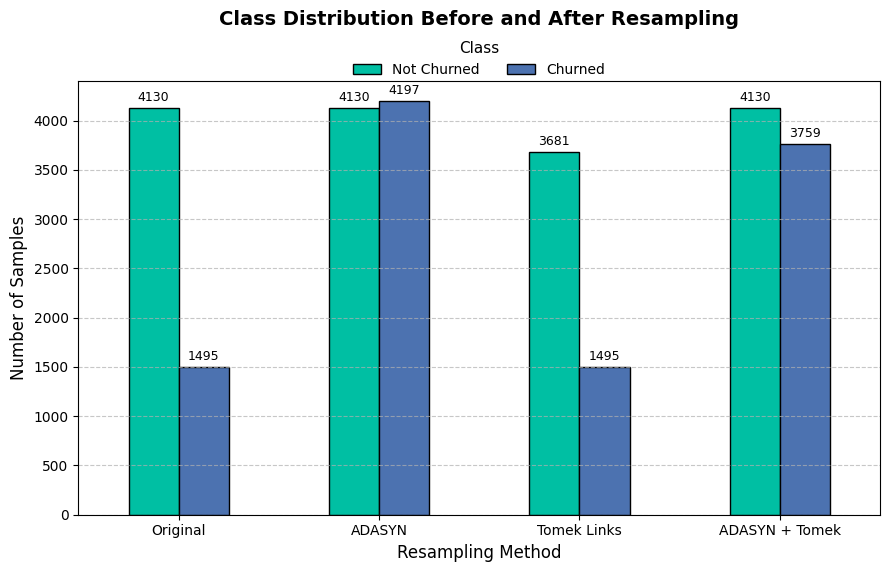

In [38]:
# Class distributions including all 4 methods
class_counts = {
    'Original': [4130, 1495],
    'ADASYN': [4130, 4197],
    'Tomek Links': [3681, 1495],
    'ADASYN + Tomek': [4130, 3759]
}

# Create DataFrame
df_counts = pd.DataFrame(class_counts, index=['Not Churned', 'Churned'])

# Define custom color scheme
colors = ['#00bfa3', '#4c72b0']  # Teal green, soft blue

# Plot
ax = df_counts.T.plot(kind='bar', figsize=(9, 6), color=colors, edgecolor='black')

# Aesthetics
plt.title('Class Distribution Before and After Resampling', fontsize=14, weight='bold', pad=40)
plt.ylabel('Number of Samples', fontsize=12)
plt.xlabel('Resampling Method', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Legend
plt.legend(
    title='Class',
    title_fontsize=11,
    fontsize=10,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.12),
    ncol=2,
    frameon=False
)

# Annotate values
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9, padding=3)

plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()


### 7.5 Model Evaluation after Resampling

#### 7.5.1 Unweighted Model Performance with ADASYN

In [39]:
# Logistic Regression (ADASYN)
lr_ada = LogisticRegression(max_iter=1000, random_state=42)
lr_ada.fit(X_train_ada, y_train_ada)
evaluate_model(lr_ada, X_test, y_test, "Logistic Regression (ADASYN)")
check_overfitting(lr_ada, X_train_ada, y_train_ada, X_test, y_test, "Logistic Regression (ADASYN)")

# Random Forest (ADASYN)
rf_ada = RandomForestClassifier(random_state=42)
rf_ada.fit(X_train_ada, y_train_ada)
evaluate_model(rf_ada, X_test, y_test, "Random Forest (ADASYN)")
check_overfitting(rf_ada, X_train_ada, y_train_ada, X_test, y_test, "Random Forest (ADASYN)")

c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


===== Logistic Regression (ADASYN) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.74      0.80      1033
           1       0.49      0.70      0.58       374

    accuracy                           0.73      1407
   macro avg       0.68      0.72      0.69      1407
weighted avg       0.77      0.73      0.74      1407

Confusion Matrix:
[[763 270]
 [112 262]]
ROC AUC  : 0.8036

Logistic Regression (ADASYN) — Overfitting Diagnostic
F1 Score   → Train: 0.7964 | Test: 0.5784
ROC AUC    → Train: 0.8741 | Test: 0.8036
Potential overfitting detected.

===== Random Forest (ADASYN) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1033
           1       0.54      0.62      0.58       374

    accuracy                           0.76      1407
   macro avg       0.70      0.71      0.71      1407
weighted avg       0.77      0.76      0.77   

#### 7.5.2 Unweighted Model Performance with Tomek Links

In [40]:
# Logistic Regression (Tomek)
lr_tomek = LogisticRegression(max_iter=1000, random_state=42)
lr_tomek.fit(X_train_tomek, y_train_tomek)
evaluate_model(lr_tomek, X_test, y_test, "Logistic Regression (Tomek)")
check_overfitting(lr_tomek, X_train_tomek, y_train_tomek, X_test, y_test, "Logistic Regression (Tomek)")

# Random Forest (Tomek)
rf_tomek = RandomForestClassifier(random_state=42)
rf_tomek.fit(X_train_tomek, y_train_tomek)
evaluate_model(rf_tomek, X_test, y_test, "Random Forest (Tomek)")
check_overfitting(rf_tomek, X_train_tomek, y_train_tomek, X_test, y_test, "Random Forest (Tomek)")

c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


===== Logistic Regression (Tomek) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1033
           1       0.60      0.64      0.62       374

    accuracy                           0.79      1407
   macro avg       0.74      0.74      0.74      1407
weighted avg       0.80      0.79      0.80      1407

Confusion Matrix:
[[876 157]
 [134 240]]
ROC AUC  : 0.8359

Logistic Regression (Tomek) — Overfitting Diagnostic
F1 Score   → Train: 0.6602 | Test: 0.6226
ROC AUC    → Train: 0.8673 | Test: 0.8359
No major overfitting symptoms detected.

===== Random Forest (Tomek) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1033
           1       0.58      0.59      0.59       374

    accuracy                           0.78      1407
   macro avg       0.71      0.72      0.72      1407
weighted avg       0.78      0.78      0.

#### 7.5.3 Unweighted Model Performance with Hybrid Resampling

In [41]:
# Logistic Regression (ADASYN + Tomek)
lr_ada_tomek = LogisticRegression(max_iter=1000, random_state=42)
lr_ada_tomek.fit(X_ada_tomek, y_ada_tomek)
evaluate_model(lr_ada_tomek, X_test, y_test, "Logistic Regression (ADASYN + Tomek)")
check_overfitting(lr_ada_tomek, X_ada_tomek, y_ada_tomek, X_test, y_test, "Logistic Regression (ADASYN + Tomek)")

# Random Forest (ADASYN + Tomek)
rf_ada_tomek = RandomForestClassifier(random_state=42)
rf_ada_tomek.fit(X_ada_tomek, y_ada_tomek)
evaluate_model(rf_ada_tomek, X_test, y_test, "Random Forest (ADASYN + Tomek)")
check_overfitting(rf_ada_tomek, X_ada_tomek, y_ada_tomek, X_test, y_test, "Random Forest (ADASYN + Tomek)")

c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


===== Logistic Regression (ADASYN + Tomek) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      1033
           1       0.52      0.68      0.59       374

    accuracy                           0.74      1407
   macro avg       0.69      0.72      0.70      1407
weighted avg       0.78      0.74      0.75      1407

Confusion Matrix:
[[793 240]
 [119 255]]
ROC AUC  : 0.8047

Logistic Regression (ADASYN + Tomek) — Overfitting Diagnostic
F1 Score   → Train: 0.7863 | Test: 0.5869
ROC AUC    → Train: 0.8778 | Test: 0.8047
Potential overfitting detected.

===== Random Forest (ADASYN + Tomek) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1033
           1       0.55      0.58      0.57       374

    accuracy                           0.76      1407
   macro avg       0.70      0.71      0.70      1407
weighted avg       0.7

#### 7.5.4 Weighted Model Performance with ADASYN

In [42]:
# Logistic Regression (ADASYN + Weighted)
lr_ada_weighted = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_ada_weighted.fit(X_train_ada, y_train_ada)
evaluate_model(lr_ada_weighted, X_test, y_test, "Logistic Regression (ADASYN + Weighted)")
check_overfitting(lr_ada_weighted, X_train_ada, y_train_ada, X_test, y_test, "Logistic Regression (ADASYN + Weighted)")

# Random Forest (ADASYN + Weighted)
rf_ada_weighted = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_ada_weighted.fit(X_train_ada, y_train_ada)
evaluate_model(rf_ada_weighted, X_test, y_test, "Random Forest (ADASYN + Weighted)")
check_overfitting(rf_ada_weighted, X_train_ada, y_train_ada, X_test, y_test, "Random Forest (ADASYN + Weighted)")

c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


===== Logistic Regression (ADASYN + Weighted) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.74      0.80      1033
           1       0.50      0.70      0.58       374

    accuracy                           0.73      1407
   macro avg       0.68      0.72      0.69      1407
weighted avg       0.77      0.73      0.74      1407

Confusion Matrix:
[[768 265]
 [112 262]]
ROC AUC  : 0.8035

Logistic Regression (ADASYN + Weighted) — Overfitting Diagnostic
F1 Score   → Train: 0.7954 | Test: 0.5816
ROC AUC    → Train: 0.8741 | Test: 0.8035
Potential overfitting detected.

===== Random Forest (ADASYN + Weighted) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1033
           1       0.56      0.62      0.59       374

    accuracy                           0.77      1407
   macro avg       0.71      0.72      0.71      1407
weighted avg 

#### 7.5.5 Weighted Model Performance with Tomek Links

In [43]:
# Logistic Regression (Tomek + Weighted) 
lr_tomek_weighted = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_tomek_weighted.fit(X_train_tomek, y_train_tomek)
evaluate_model(lr_tomek_weighted, X_test, y_test, "Logistic Regression (Tomek + Weighted)")
check_overfitting(lr_tomek_weighted, X_train_tomek, y_train_tomek, X_test, y_test, "Logistic Regression (Tomek + Weighted)")

# Random Forest (Tomek + Weighted) 
rf_tomek_weighted = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_tomek_weighted.fit(X_train_tomek, y_train_tomek)
evaluate_model(rf_tomek_weighted, X_test, y_test, "Random Forest (Tomek + Weighted)")
check_overfitting(rf_tomek_weighted, X_train_tomek, y_train_tomek, X_test, y_test, "Random Forest (Tomek + Weighted)")

c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


===== Logistic Regression (Tomek + Weighted) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.69      0.79      1033
           1       0.49      0.81      0.61       374

    accuracy                           0.72      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.72      0.74      1407

Confusion Matrix:
[[714 319]
 [ 70 304]]
ROC AUC  : 0.8354

Logistic Regression (Tomek + Weighted) — Overfitting Diagnostic
F1 Score   → Train: 0.6745 | Test: 0.6098
ROC AUC    → Train: 0.8672 | Test: 0.8354
No major overfitting symptoms detected.

===== Random Forest (Tomek + Weighted) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1033
           1       0.57      0.57      0.57       374

    accuracy                           0.77      1407
   macro avg       0.71      0.71      0.71      1407
weighted

#### 7.5.6 Weighted Model Performance with Hybrid Resampling

In [44]:
# Weighted Logistic Regression (ADASYN + Tomek)
lr_ada_tomek_weighted = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_ada_tomek_weighted.fit(X_ada_tomek, y_ada_tomek)
evaluate_model(lr_ada_tomek_weighted, X_test, y_test, "Logistic Regression (ADASYN + Tomek + Weighted)")
check_overfitting(lr_ada_tomek_weighted, X_ada_tomek, y_ada_tomek, X_test, y_test, "Logistic Regression (ADASYN + Tomek + Weighted)")

# Weighted Random Forest (ADASYN + Tomek)
rf_ada_tomek_weighted = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_ada_tomek_weighted.fit(X_ada_tomek, y_ada_tomek)
evaluate_model(rf_ada_tomek_weighted, X_test, y_test, "Random Forest (ADASYN + Tomek + Weighted)")
check_overfitting(rf_ada_tomek_weighted, X_ada_tomek, y_ada_tomek, X_test, y_test, "Random Forest (ADASYN + Tomek + Weighted)")

c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


===== Logistic Regression (ADASYN + Tomek + Weighted) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.75      0.81      1033
           1       0.50      0.70      0.58       374

    accuracy                           0.73      1407
   macro avg       0.69      0.72      0.69      1407
weighted avg       0.77      0.73      0.75      1407

Confusion Matrix:
[[772 261]
 [112 262]]
ROC AUC  : 0.8052

Logistic Regression (ADASYN + Tomek + Weighted) — Overfitting Diagnostic
F1 Score   → Train: 0.7890 | Test: 0.5842
ROC AUC    → Train: 0.8777 | Test: 0.8052
Potential overfitting detected.

===== Random Forest (ADASYN + Tomek + Weighted) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1033
           1       0.55      0.57      0.56       374

    accuracy                           0.76      1407
   macro avg       0.70      0.70      0.70

### 7.6 Overfitting Diagnostic

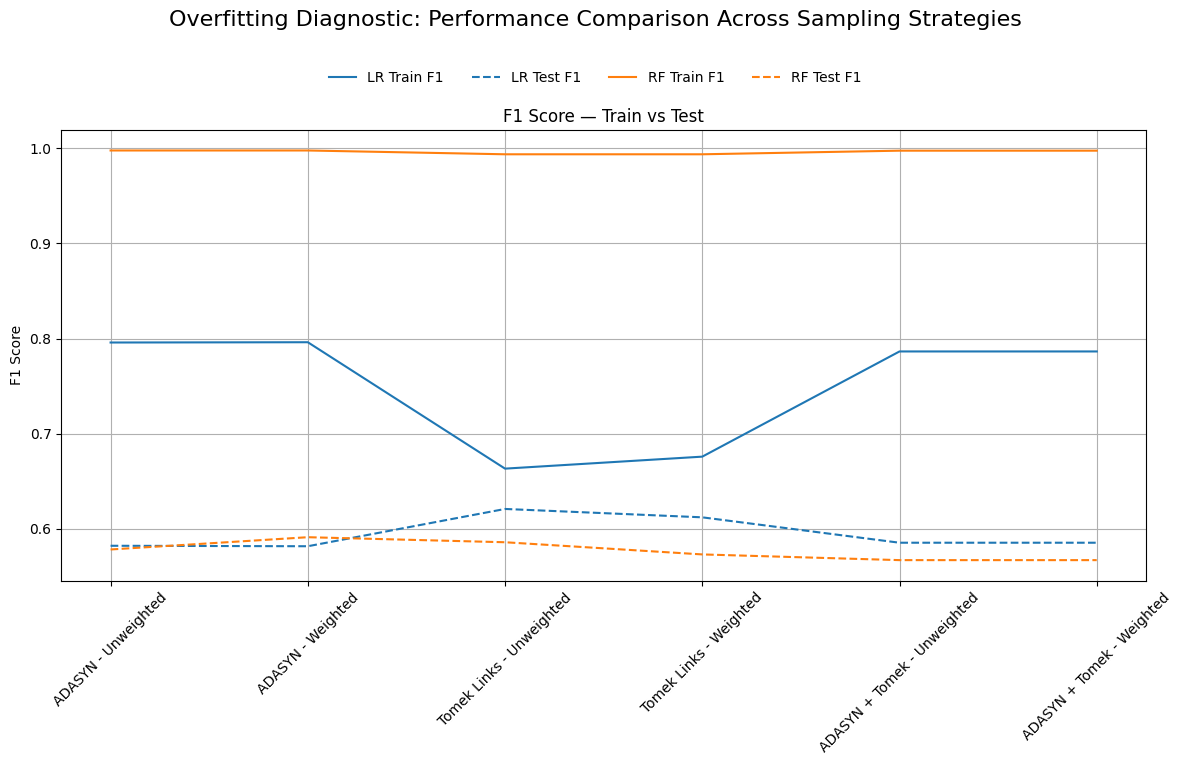

In [45]:
# Create DataFrame
data = {
    'Model': ['LogReg'] * 6 + ['RF'] * 6,
    'Sampling': ['ADASYN', 'ADASYN', 'Tomek Links', 'Tomek Links', 'ADASYN + Tomek', 'ADASYN + Tomek'] * 2,
    'Variation': ['Unweighted', 'Weighted'] * 6,
    'F1_Train': [0.7958, 0.7961, 0.6632, 0.6758, 0.7864, 0.7864, 0.9977, 0.9977, 0.9937, 0.9937, 0.9975, 0.9975],
    'F1_Test':  [0.5821, 0.5816, 0.6208, 0.6120, 0.5853, 0.5853, 0.5782, 0.5911, 0.5858, 0.5730, 0.5670, 0.5670],
    'AUC_Train': [0.8739, 0.8740, 0.8673, 0.8669, 0.8778, 0.8778, 0.9999, 0.9999, 0.9998, 0.9996, 0.9999, 0.9999],
    'AUC_Test':  [0.8044, 0.8031, 0.8395, 0.8346, 0.8048, 0.8048, 0.8057, 0.8079, 0.8105, 0.8115, 0.8011, 0.8011]
}
df = pd.DataFrame(data)

# Create X-axis labels
df['Label'] = df['Sampling'] + " - " + df['Variation']

# Split data
logreg = df[df['Model'] == 'LogReg']
rf = df[df['Model'] == 'RF']

# Setup subplots with increased height for better spacing
fig, ax = plt.subplots(1, 1, figsize=(12, 8)) # Changed to 1 subplot and adjusted figsize

# Color scheme
logreg_f1_color = '#1f77b4'   # blue
rf_f1_color = '#ff7f0e'       # orange

# --- F1 Score Plot ---
ax.plot(logreg['Label'], logreg['F1_Train'], label='LR Train F1', color=logreg_f1_color, linestyle='-')
ax.plot(logreg['Label'], logreg['F1_Test'], label='LR Test F1', color=logreg_f1_color, linestyle='--')
ax.plot(rf['Label'], rf['F1_Train'], label='RF Train F1', color=rf_f1_color, linestyle='-')
ax.plot(rf['Label'], rf['F1_Test'], label='RF Test F1', color=rf_f1_color, linestyle='--')
ax.set_title('F1 Score — Train vs Test')
ax.set_ylabel('F1 Score')
ax.tick_params(axis='x', rotation=45)
ax.grid(True)

# --- ROC AUC Plot --- (REMOVED THIS SECTION)

# Main Title with increased font size and padding
fig.suptitle('Overfitting Diagnostic: Performance Comparison Across Sampling Strategies', fontsize=16, y=1.0)

# Unified Legend with better positioning
legend_elements = [
    Line2D([0], [0], color=logreg_f1_color, linestyle='-', label='LR Train F1'),
    Line2D([0], [0], color=logreg_f1_color, linestyle='--', label='LR Test F1'),
    Line2D([0], [0], color=rf_f1_color, linestyle='-', label='RF Train F1'),
    Line2D([0], [0], color=rf_f1_color, linestyle='--', label='RF Test F1')
]

# Place legend below the main title and above the plots
fig.legend(
    handles=legend_elements,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.94), # Adjusted to be under the main title
    ncol=4,
    fontsize=10,
    frameon=False # Removed frame for cleaner look
)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.05, 1, 0.9]) # Adjusted rect for legend at top
plt.subplots_adjust(top=0.85) # Adjusted top margin for legend for single plot
plt.show()

## 8.0 Hyperparameter Tuning

### 8.1 RandomizedSearchCV

In [46]:
# # Define search spaces
# lr_param_dist = {
#     'C': uniform(0.001, 10),
#     'penalty': ['l1', 'l2'],
#     'solver': ['liblinear']
# }

# rf_param_dist = {
#     'n_estimators': randint(50, 300),
#     'max_depth': [None, 10, 20, 30],
#     'max_features': ['sqrt', 'log2']
# }

lr_param_dist = {
    'C': uniform(0.01, 1.0),  # Narrower range if initial results cluster mid-range
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']  # 'saga' handles both l1 & l2 + large-scale support
}

rf_param_dist = {
    'n_estimators': randint(100, 300),              # More trees, but capped
    'max_depth': [5, 10, 15, None],                 # Control tree depth
    'min_samples_split': [2, 5, 10],                # Prevent deep splits
    'min_samples_leaf': [1, 2, 4, 8],               # Prevent overfitting small branches
    'max_features': ['sqrt', 'log2'],              # Encourage diversity
    'class_weight': ['balanced', None]             # Handle imbalance natively
}

In [47]:
# Model configurations for randomized search, including ADASYN + Tomek
rand_model_configs = {
    # ADASYN only
    "LR_ADA_Unweighted": (LogisticRegression(max_iter=1000, random_state=42), lr_param_dist, X_train_ada, y_train_ada),
    "LR_ADA_Weighted": (LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42), lr_param_dist, X_train_ada, y_train_ada),
    "RF_ADA_Unweighted": (RandomForestClassifier(random_state=42), rf_param_dist, X_train_ada, y_train_ada),
    "RF_ADA_Weighted": (RandomForestClassifier(class_weight='balanced', random_state=42), rf_param_dist, X_train_ada, y_train_ada),

    # Tomek only
    "LR_Tomek_Unweighted": (LogisticRegression(max_iter=1000, random_state=42), lr_param_dist, X_train_tomek, y_train_tomek),
    "LR_Tomek_Weighted": (LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42), lr_param_dist, X_train_tomek, y_train_tomek),
    "RF_Tomek_Unweighted": (RandomForestClassifier(random_state=42), rf_param_dist, X_train_tomek, y_train_tomek),
    "RF_Tomek_Weighted": (RandomForestClassifier(class_weight='balanced', random_state=42), rf_param_dist, X_train_tomek, y_train_tomek),

    # ADASYN + Tomek
    "LR_ADATomek_Unweighted": (LogisticRegression(max_iter=1000, random_state=42), lr_param_dist, X_ada_tomek, y_ada_tomek),
    "LR_ADATomek_Weighted": (LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42), lr_param_dist, X_ada_tomek, y_ada_tomek),
    "RF_ADATomek_Unweighted": (RandomForestClassifier(random_state=42), rf_param_dist, X_ada_tomek, y_ada_tomek),
    "RF_ADATomek_Weighted": (RandomForestClassifier(class_weight='balanced', random_state=42), rf_param_dist, X_ada_tomek, y_ada_tomek),
}

# Initialize dictionary to store results
rand_search_results = {}

In [48]:
# Run randomized search
for name, (model, param_dist, X_train, y_train) in rand_model_configs.items():
    print(f"Running RandomizedSearchCV for {name}...")
    search = RandomizedSearchCV(
        model,
        param_distributions=param_dist,
        n_iter=20,
        scoring='f1',
        cv=5,
        random_state=42,
        n_jobs=-1
    )
    search.fit(X_train, y_train)
    rand_search_results[name] = search

Running RandomizedSearchCV for LR_ADA_Unweighted...
Running RandomizedSearchCV for LR_ADA_Weighted...
Running RandomizedSearchCV for RF_ADA_Unweighted...
Running RandomizedSearchCV for RF_ADA_Weighted...
Running RandomizedSearchCV for LR_Tomek_Unweighted...
Running RandomizedSearchCV for LR_Tomek_Weighted...
Running RandomizedSearchCV for RF_Tomek_Unweighted...
Running RandomizedSearchCV for RF_Tomek_Weighted...
Running RandomizedSearchCV for LR_ADATomek_Unweighted...
Running RandomizedSearchCV for LR_ADATomek_Weighted...
Running RandomizedSearchCV for RF_ADATomek_Unweighted...
Running RandomizedSearchCV for RF_ADATomek_Weighted...


In [49]:
# Print best parameters and F1 scores
for name, search in rand_search_results.items():
    print(f"{name} → Best Params: {search.best_params_} | Best F1 Score: {search.best_score_:.4f}")

LR_ADA_Unweighted → Best Params: {'C': np.float64(0.31424224295953773), 'penalty': 'l2', 'solver': 'liblinear'} | Best F1 Score: 0.7817
LR_ADA_Weighted → Best Params: {'C': np.float64(0.31424224295953773), 'penalty': 'l2', 'solver': 'liblinear'} | Best F1 Score: 0.7810
RF_ADA_Unweighted → Best Params: {'class_weight': None, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 139} | Best F1 Score: 0.8217
RF_ADA_Weighted → Best Params: {'class_weight': None, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 139} | Best F1 Score: 0.8217
LR_Tomek_Unweighted → Best Params: {'C': np.float64(0.3845401188473625), 'penalty': 'l1', 'solver': 'liblinear'} | Best F1 Score: 0.6522
LR_Tomek_Weighted → Best Params: {'C': np.float64(0.6111150117432088), 'penalty': 'l2', 'solver': 'liblinear'} | Best F1 Score: 0.6740
RF_Tomek_Unweighted → Best Params: {'class_weight': 'balanced', 'max_depth': 15, '

In [50]:
models = {
    # ADASYN only
    "Logistic Regression (Unweighted - ADASYN)": rand_search_results["LR_ADA_Unweighted"].best_estimator_,
    "Logistic Regression (Weighted - ADASYN)": rand_search_results["LR_ADA_Weighted"].best_estimator_,
    "Random Forest (Unweighted - ADASYN)": rand_search_results["RF_ADA_Unweighted"].best_estimator_,
    "Random Forest (Weighted - ADASYN)": rand_search_results["RF_ADA_Weighted"].best_estimator_,

    # Tomek only
    "Logistic Regression (Unweighted - Tomek)": rand_search_results["LR_Tomek_Unweighted"].best_estimator_,
    "Logistic Regression (Weighted - Tomek)": rand_search_results["LR_Tomek_Weighted"].best_estimator_,
    "Random Forest (Unweighted - Tomek)": rand_search_results["RF_Tomek_Unweighted"].best_estimator_,
    "Random Forest (Weighted - Tomek)": rand_search_results["RF_Tomek_Weighted"].best_estimator_,

    # ADASYN + Tomek (hybrid)
    "Logistic Regression (Unweighted - ADATomek)": rand_search_results["LR_ADATomek_Unweighted"].best_estimator_,
    "Logistic Regression (Weighted - ADATomek)": rand_search_results["LR_ADATomek_Weighted"].best_estimator_,
    "Random Forest (Unweighted - ADATomek)": rand_search_results["RF_ADATomek_Unweighted"].best_estimator_,
    "Random Forest (Weighted - ADATomek)": rand_search_results["RF_ADATomek_Weighted"].best_estimator_,
}

In [51]:
def evaluate_final(model, X_test, y_test, label=""):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"===== {label} =====")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=2))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f"ROC AUC  : {roc_auc:.4f}\n")

In [52]:
def check_overfitting(model, X_train, y_train, X_test, y_test, label="Model"):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    f1_train = f1_score(y_train, y_train_pred)
    f1_test = f1_score(y_test, y_test_pred)
    auc_train = roc_auc_score(y_train, y_train_proba)
    auc_test = roc_auc_score(y_test, y_test_proba)

    print(f"{label} — Overfitting Diagnostic")
    print(f"F1 Score   → Train: {f1_train:.4f} | Test: {f1_test:.4f}")
    print(f"ROC AUC    → Train: {auc_train:.4f} | Test: {auc_test:.4f}")
    if abs(f1_train - f1_test) > 0.1 or abs(auc_train - auc_test) > 0.1:
        print("Potential overfitting detected.\n")
    else:
        print("No major overfitting symptoms detected.\n")

### 8.1.1 Model Evaluation after RandomizedSearchCV

In [53]:
resampling_sources = {
    "ADASYN": (X_train_ada, y_train_ada),
    "Tomek": (X_train_tomek, y_train_tomek),
    "ADATomek": (X_ada_tomek, y_ada_tomek)
}

for label, model in models.items():
    # Determine which training set to use (prioritize more specific matches)
    if "ADATomek" in label:
        method = "ADATomek"
    elif "ADASYN" in label:
        method = "ADASYN"
    elif "Tomek" in label:
        method = "Tomek"
    else:
        raise ValueError(f"Unknown resampling strategy in label: {label}")

    X_train_resampled, y_train_resampled = resampling_sources[method]

    # Evaluate on test set
    evaluate_final(model, X_test, y_test, label)

    # Overfitting check
    check_overfitting(model, X_train_resampled, y_train_resampled, X_test, y_test, label)

===== Logistic Regression (Unweighted - ADASYN) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.74      0.80      1033
           1       0.50      0.71      0.58       374

    accuracy                           0.73      1407
   macro avg       0.69      0.73      0.69      1407
weighted avg       0.78      0.73      0.75      1407

Confusion Matrix:
[[766 267]
 [109 265]]
ROC AUC  : 0.8035

Logistic Regression (Unweighted - ADASYN) — Overfitting Diagnostic
F1 Score   → Train: 0.7965 | Test: 0.5850
ROC AUC    → Train: 0.8737 | Test: 0.8035
Potential overfitting detected.

===== Logistic Regression (Weighted - ADASYN) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.74      0.80      1033
           1       0.50      0.70      0.58       374

    accuracy                           0.73      1407
   macro avg       0.68      0.72      0.69      1407
wei

### 8.2 GridSearchCV

In [54]:
# Parameter grids
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2']
}

In [55]:
# Define all model configs (including ADASYN + Tomek)
model_configs = {
    # ADASYN only
    "LR_ADA_Unweighted": (LogisticRegression(max_iter=1000, random_state=42), lr_param_grid, X_train_ada, y_train_ada),
    "LR_ADA_Weighted":   (LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42), lr_param_grid, X_train_ada, y_train_ada),
    "RF_ADA_Unweighted": (RandomForestClassifier(random_state=42), rf_param_grid, X_train_ada, y_train_ada),
    "RF_ADA_Weighted":   (RandomForestClassifier(class_weight='balanced', random_state=42), rf_param_grid, X_train_ada, y_train_ada),

    # Tomek only
    "LR_Tomek_Unweighted": (LogisticRegression(max_iter=1000, random_state=42), lr_param_grid, X_train_tomek, y_train_tomek),
    "LR_Tomek_Weighted":   (LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42), lr_param_grid, X_train_tomek, y_train_tomek),
    "RF_Tomek_Unweighted": (RandomForestClassifier(random_state=42), rf_param_grid, X_train_tomek, y_train_tomek),
    "RF_Tomek_Weighted":   (RandomForestClassifier(class_weight='balanced', random_state=42), rf_param_grid, X_train_tomek, y_train_tomek),

    # ADASYN + Tomek (hybrid)
    "LR_ADATomek_Unweighted": (LogisticRegression(max_iter=1000, random_state=42), lr_param_grid, X_ada_tomek, y_ada_tomek),
    "LR_ADATomek_Weighted":   (LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42), lr_param_grid, X_ada_tomek, y_ada_tomek),
    "RF_ADATomek_Unweighted": (RandomForestClassifier(random_state=42), rf_param_grid, X_ada_tomek, y_ada_tomek),
    "RF_ADATomek_Weighted":   (RandomForestClassifier(class_weight='balanced', random_state=42), rf_param_grid, X_ada_tomek, y_ada_tomek),
}

In [56]:
# Run GridSearchCV for each config
grid_results = {}
for name, (model, param_grid, X_train, y_train) in model_configs.items():
    print(f"Running GridSearchCV for {name}...")
    grid = GridSearchCV(model, param_grid, scoring='f1', cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    grid_results[name] = grid

Running GridSearchCV for LR_ADA_Unweighted...
Running GridSearchCV for LR_ADA_Weighted...
Running GridSearchCV for RF_ADA_Unweighted...
Running GridSearchCV for RF_ADA_Weighted...
Running GridSearchCV for LR_Tomek_Unweighted...
Running GridSearchCV for LR_Tomek_Weighted...
Running GridSearchCV for RF_Tomek_Unweighted...
Running GridSearchCV for RF_Tomek_Weighted...
Running GridSearchCV for LR_ADATomek_Unweighted...
Running GridSearchCV for LR_ADATomek_Weighted...
Running GridSearchCV for RF_ADATomek_Unweighted...
Running GridSearchCV for RF_ADATomek_Weighted...


In [57]:
# Print results
for name, grid in grid_results.items():
    print(f"{name} → Best Params: {grid.best_params_} | Best F1 Score: {grid.best_score_:.4f}")

LR_ADA_Unweighted → Best Params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'} | Best F1 Score: 0.7821
LR_ADA_Weighted → Best Params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'} | Best F1 Score: 0.7819
RF_ADA_Unweighted → Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200} | Best F1 Score: 0.8234
RF_ADA_Weighted → Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200} | Best F1 Score: 0.8206
LR_Tomek_Unweighted → Best Params: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'} | Best F1 Score: 0.6542
LR_Tomek_Weighted → Best Params: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'} | Best F1 Score: 0.6733
RF_Tomek_Unweighted → Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200} | Best F1 Score: 0.6404
RF_Tomek_Weighted → Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200} | Best F1 Score: 0.6779
LR_ADATomek_Unweighted → Best Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'} | 

In [58]:
# Extract best estimators from grid_results
models = {
    # ADASYN only
    "Logistic Regression (Unweighted - ADASYN)": grid_results["LR_ADA_Unweighted"].best_estimator_,
    "Logistic Regression (Weighted - ADASYN)": grid_results["LR_ADA_Weighted"].best_estimator_,
    "Random Forest (Unweighted - ADASYN)": grid_results["RF_ADA_Unweighted"].best_estimator_,
    "Random Forest (Weighted - ADASYN)": grid_results["RF_ADA_Weighted"].best_estimator_,

    # Tomek only
    "Logistic Regression (Unweighted - Tomek)": grid_results["LR_Tomek_Unweighted"].best_estimator_,
    "Logistic Regression (Weighted - Tomek)": grid_results["LR_Tomek_Weighted"].best_estimator_,
    "Random Forest (Unweighted - Tomek)": grid_results["RF_Tomek_Unweighted"].best_estimator_,
    "Random Forest (Weighted - Tomek)": grid_results["RF_Tomek_Weighted"].best_estimator_,

    # ADASYN + Tomek (hybrid)
    "Logistic Regression (Unweighted - ADATomek)": grid_results["LR_ADATomek_Unweighted"].best_estimator_,
    "Logistic Regression (Weighted - ADATomek)": grid_results["LR_ADATomek_Weighted"].best_estimator_,
    "Random Forest (Unweighted - ADATomek)": grid_results["RF_ADATomek_Unweighted"].best_estimator_,
    "Random Forest (Weighted - ADATomek)": grid_results["RF_ADATomek_Weighted"].best_estimator_,
}

### 8.2.1 Model Evaluation after GridSearchCV

In [59]:
# Mapping models to their training data
resampling_sources = {
    "ADASYN": (X_train_ada, y_train_ada),
    "Tomek": (X_train_tomek, y_train_tomek),
    "ADATomek": (X_ada_tomek, y_ada_tomek)
}

# Loop through each model
for label, model in models.items():
    # Determine which resampling strategy the model used
    if "ADATomek" in label:
        resampling_key = "ADATomek"
    elif "ADASYN" in label:
        resampling_key = "ADASYN"
    elif "Tomek" in label:
        resampling_key = "Tomek"
    else:
        raise ValueError(f"Unknown resampling strategy in label: {label}")

    X_train_resampled, y_train_resampled = resampling_sources[resampling_key]

    # Evaluate and check overfitting
    evaluate_final(model, X_test, y_test, label)
    check_overfitting(model, X_train_resampled, y_train_resampled, X_test, y_test, label)

===== Logistic Regression (Unweighted - ADASYN) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.74      0.80      1033
           1       0.50      0.71      0.59       374

    accuracy                           0.73      1407
   macro avg       0.69      0.73      0.69      1407
weighted avg       0.78      0.73      0.74      1407

Confusion Matrix:
[[764 269]
 [108 266]]
ROC AUC  : 0.8061

Logistic Regression (Unweighted - ADASYN) — Overfitting Diagnostic
F1 Score   → Train: 0.7971 | Test: 0.5853
ROC AUC    → Train: 0.8735 | Test: 0.8061
Potential overfitting detected.

===== Logistic Regression (Weighted - ADASYN) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.74      0.80      1033
           1       0.50      0.71      0.59       374

    accuracy                           0.73      1407
   macro avg       0.69      0.73      0.70      1407
wei

## 8.3 Overfitting Diagnostic after Hyperparameter Tuning

In [60]:
# Tweaked RandomizedSearchCV Results (df_after)
tweaked_data = {
    "Model": [
        "LogReg", "LogReg", "LogReg", "LogReg",
        "LogReg", "LogReg", "RF", "RF",
        "RF", "RF", "RF", "RF"
    ],
    "Variation": [
        "ADASYN Unweighted", "ADASYN Weighted", "Tomek Unweighted", "Tomek Weighted",
        "ADASYN+Tomek Unweighted", "ADASYN+Tomek Weighted",
        "ADASYN Unweighted", "ADASYN Weighted", "Tomek Unweighted", "Tomek Weighted",
        "ADASYN+Tomek Unweighted", "ADASYN+Tomek Weighted"
    ],
    "F1_Train": [0.7965, 0.7959, 0.6606, 0.6756, 0.7858, 0.7886, 0.9390, 0.9390, 0.7418, 0.7418, 0.9975, 0.9975],
    "F1_Test":  [0.5850, 0.5816, 0.6234, 0.6113, 0.5902, 0.5826, 0.6002, 0.6002, 0.6230, 0.6230, 0.5666, 0.5666],
    "AUC_Train": [0.8737, 0.8741, 0.8671, 0.8669, 0.8766, 0.8777, 0.9850, 0.9850, 0.9215, 0.9215, 0.9999, 0.9999],
    "AUC_Test":  [0.8035, 0.8043, 0.8365, 0.8348, 0.8099, 0.8057, 0.8169, 0.8169, 0.8365, 0.8365, 0.8027, 0.8027]
}
df_after = pd.DataFrame(tweaked_data)

# GridSearchCV Results (df_grid)
grid_data = {
    "Model": [
        "LogReg", "LogReg", "LogReg", "LogReg",
        "LogReg", "LogReg", "RF", "RF",
        "RF", "RF", "RF", "RF"
    ],
    "Variation": tweaked_data["Variation"],
    "F1_Train": [0.7971, 0.7966, 0.6625, 0.6758, 0.7868, 0.7902, 0.9873, 0.9871, 0.7756, 0.8031, 0.9884, 0.9875],
    "F1_Test":  [0.5853, 0.5863, 0.6208, 0.6123, 0.5909, 0.5901, 0.5788, 0.5874, 0.6096, 0.6238, 0.5733, 0.5751],
    "AUC_Train": [0.8735, 0.8735, 0.8674, 0.8671, 0.8770, 0.8772, 0.9997, 0.9998, 0.9572, 0.9518, 0.9997, 0.9998],
    "AUC_Test":  [0.8061, 0.8061, 0.8358, 0.8351, 0.8084, 0.8084, 0.8094, 0.8113, 0.8324, 0.8343, 0.8055, 0.8057]
}
df_grid = pd.DataFrame(grid_data)

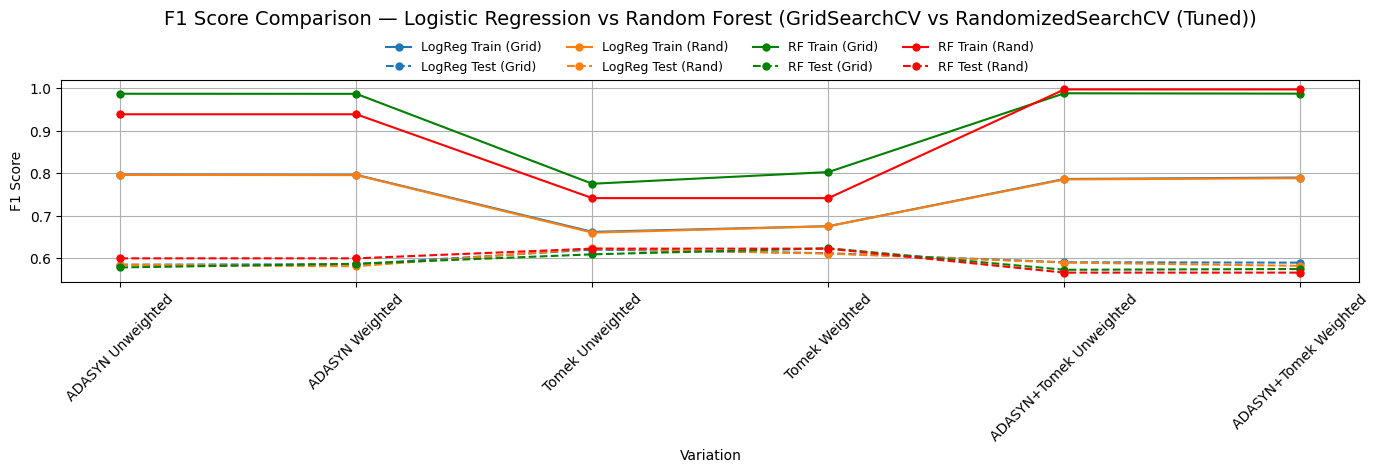

In [61]:
# No filtering – include all variations, including ADASYN + Tomek
df_grid_filtered = df_grid
df_after_filtered = df_after

# Split by model
logreg_grid = df_grid_filtered[df_grid_filtered['Model'] == 'LogReg']
rf_grid = df_grid_filtered[df_grid_filtered['Model'] == 'RF']
logreg_rand = df_after_filtered[df_after_filtered['Model'] == 'LogReg']
rf_rand = df_after_filtered[df_after_filtered['Model'] == 'RF']

# Optional: consistent variation order (only if all exist)
variation_order = ['Original', 'ADASYN', 'Tomek Links', 'ADASYN + Tomek']
for df in [logreg_grid, rf_grid, logreg_rand, rf_rand]:
    if set(variation_order).issubset(df['Variation'].unique()):
        df.sort_values(by='Variation', key=lambda col: [variation_order.index(val) for val in col], inplace=True)

# Color definitions
f1_grid_color = '#1f77b4'   # Blue for GridSearchCV
f1_rand_color = '#ff7f0e'   # Orange for RandomSearchCV

# Create single plot
plt.figure(figsize=(14, 6))

# Logistic Regression lines with markers
plt.plot(logreg_grid['Variation'], logreg_grid['F1_Train'], color=f1_grid_color, linestyle='-', marker='o', markersize=5, label='LogReg Train (Grid)')
plt.plot(logreg_grid['Variation'], logreg_grid['F1_Test'], color=f1_grid_color, linestyle='--', marker='o', markersize=5, label='LogReg Test (Grid)')
plt.plot(logreg_rand['Variation'], logreg_rand['F1_Train'], color=f1_rand_color, linestyle='-', marker='o', markersize=5, label='LogReg Train (Rand)')
plt.plot(logreg_rand['Variation'], logreg_rand['F1_Test'], color=f1_rand_color, linestyle='--', marker='o', markersize=5, label='LogReg Test (Rand)')

# Random Forest lines with markers
plt.plot(rf_grid['Variation'], rf_grid['F1_Train'], color='green', linestyle='-', marker='o', markersize=5, label='RF Train (Grid)')
plt.plot(rf_grid['Variation'], rf_grid['F1_Test'], color='green', linestyle='--', marker='o', markersize=5, label='RF Test (Grid)')
plt.plot(rf_rand['Variation'], rf_rand['F1_Train'], color='red', linestyle='-', marker='o', markersize=5, label='RF Train (Rand)')
plt.plot(rf_rand['Variation'], rf_rand['F1_Test'], color='red', linestyle='--', marker='o', markersize=5, label='RF Test (Rand)')

# Labels and styling
plt.title(
    'F1 Score Comparison — Logistic Regression vs Random Forest (GridSearchCV vs RandomizedSearchCV (Tuned))',
    fontsize=14,
    loc='center',
    pad=40
)
plt.ylabel('F1 Score')
plt.xlabel('Variation')
plt.xticks(rotation=45)
plt.grid(True)

# Legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=4, fontsize=9, frameon=False)

# Layout
plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.show()


## 9.0 Threshold Tuning

In [62]:
def tune_threshold(model, X_test, y_test, label, thresholds=np.arange(0.1, 0.91, 0.05)):
    y_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)  # Calculate AUC once, outside the loop
    
    print(f"\n===== Threshold Tuning: {label} =====")
    print(f"{'Threshold':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    
    best_f1 = 0
    best_threshold = 0.5
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
        
        print(f"{thresh:<10.2f} {prec:<10.2f} {rec:<10.2f} {f1:<10.2f}")
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh

    print(f"\nBest F1 Score = {best_f1:.4f} at Threshold = {best_threshold:.2f}")
    print(f"ROC AUC Score = {auc:.4f}")
    
    return best_threshold, best_f1, auc

# def tune_threshold_by_recall(model, X_test, y_test, label, thresholds=np.arange(0.1, 0.91, 0.05)):
#     y_proba = model.predict_proba(X_test)[:, 1]
#     auc = roc_auc_score(y_test, y_proba)  # Calculate AUC once, outside the loop
    
#     print(f"\n===== Threshold Tuning: {label} =====")
#     print(f"{'Threshold':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    
#     best_recall = 0
#     best_threshold = None
#     best_f1 = 0
#     for thresh in thresholds:
#         y_pred = (y_proba >= thresh).astype(int)
        
#         with warnings.catch_warnings():
#             warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
#             prec = precision_score(y_test, y_pred, zero_division=0)
#             rec = recall_score(y_test, y_pred, zero_division=0)
#             f1 = f1_score(y_test, y_pred, zero_division=0)
        
#         print(f"{thresh:<10.2f} {prec:<10.2f} {rec:<10.2f} {f1:<10.2f}")
        
#         # Only consider thresholds where precision ≥ 0.50
#         if rec > best_recall and prec >= 0.50:
#             best_recall = rec
#             best_threshold = thresh
#             best_f1 = f1

#     if best_threshold is not None:
#         print(f"\nBest Recall = {best_recall:.4f} at Threshold = {best_threshold:.2f}")
#         print(f"Corresponding F1 Score = {best_f1:.4f}")
#     else:
#         print("\nNo threshold found where Precision ≥ 0.50.")

#     print(f"ROC AUC Score = {auc:.4f}")
    
#     return best_threshold, best_recall, best_f1, auc

In [63]:
# Models from RandomizedSearchCV (Advanced)
lr_ada         = rand_search_results["LR_ADA_Unweighted"].best_estimator_
lr_ada_w       = rand_search_results["LR_ADA_Weighted"].best_estimator_
rf_ada         = rand_search_results["RF_ADA_Unweighted"].best_estimator_
rf_ada_w       = rand_search_results["RF_ADA_Weighted"].best_estimator_

lr_tomek       = rand_search_results["LR_Tomek_Unweighted"].best_estimator_
lr_tomek_w     = rand_search_results["LR_Tomek_Weighted"].best_estimator_
rf_tomek       = rand_search_results["RF_Tomek_Unweighted"].best_estimator_
rf_tomek_w     = rand_search_results["RF_Tomek_Weighted"].best_estimator_

lr_ada_tomek   = rand_search_results["LR_ADATomek_Unweighted"].best_estimator_
lr_ada_tomek_w = rand_search_results["LR_ADATomek_Weighted"].best_estimator_
rf_ada_tomek   = rand_search_results["RF_ADATomek_Unweighted"].best_estimator_
rf_ada_tomek_w = rand_search_results["RF_ADATomek_Weighted"].best_estimator_

In [64]:
# Threshold tuning for all 12 models

# ADASYN only
tune_threshold(lr_ada, X_test, y_test, "Logistic Regression (Unweighted - ADASYN)")
tune_threshold(lr_ada_w, X_test, y_test, "Logistic Regression (Weighted - ADASYN)")
tune_threshold(rf_ada, X_test, y_test, "Random Forest (Unweighted - ADASYN)")
tune_threshold(rf_ada_w, X_test, y_test, "Random Forest (Weighted - ADASYN)")

# Tomek only
tune_threshold(lr_tomek, X_test, y_test, "Logistic Regression (Unweighted - Tomek)")
tune_threshold(lr_tomek_w, X_test, y_test, "Logistic Regression (Weighted - Tomek)")
tune_threshold(rf_tomek, X_test, y_test, "Random Forest (Unweighted - Tomek)")
tune_threshold(rf_tomek_w, X_test, y_test, "Random Forest (Weighted - Tomek)")

# ADASYN + Tomek (hybrid)
tune_threshold(lr_ada_tomek, X_test, y_test, "Logistic Regression (Unweighted - ADATomek)")
tune_threshold(lr_ada_tomek_w, X_test, y_test, "Logistic Regression (Weighted - ADATomek)")
tune_threshold(rf_ada_tomek, X_test, y_test, "Random Forest (Unweighted - ADATomek)")
tune_threshold(rf_ada_tomek_w, X_test, y_test, "Random Forest (Weighted - ADATomek)")

# # Threshold tuning for all 12 models (OPTIMIZING FOR RECALL)

# # ADASYN only
# tune_threshold_by_recall(lr_ada, X_test, y_test, "Logistic Regression (Unweighted - ADASYN)")
# tune_threshold_by_recall(lr_ada_w, X_test, y_test, "Logistic Regression (Weighted - ADASYN)")
# tune_threshold_by_recall(rf_ada, X_test, y_test, "Random Forest (Unweighted - ADASYN)")
# tune_threshold_by_recall(rf_ada_w, X_test, y_test, "Random Forest (Weighted - ADASYN)")

# # Tomek only
# tune_threshold_by_recall(lr_tomek, X_test, y_test, "Logistic Regression (Unweighted - Tomek)")
# tune_threshold_by_recall(lr_tomek_w, X_test, y_test, "Logistic Regression (Weighted - Tomek)")
# tune_threshold_by_recall(rf_tomek, X_test, y_test, "Random Forest (Unweighted - Tomek)")
# tune_threshold_by_recall(rf_tomek_w, X_test, y_test, "Random Forest (Weighted - Tomek)")

# # ADASYN + Tomek (hybrid)
# tune_threshold_by_recall(lr_ada_tomek, X_test, y_test, "Logistic Regression (Unweighted - ADATomek)")
# tune_threshold_by_recall(lr_ada_tomek_w, X_test, y_test, "Logistic Regression (Weighted - ADATomek)")
# tune_threshold_by_recall(rf_ada_tomek, X_test, y_test, "Random Forest (Unweighted - ADATomek)")
# tune_threshold_by_recall(rf_ada_tomek_w, X_test, y_test, "Random Forest (Weighted - ADATomek)")


===== Threshold Tuning: Logistic Regression (Unweighted - ADASYN) =====
Threshold  Precision  Recall     F1-Score  
0.10       0.34       0.97       0.50      
0.15       0.37       0.94       0.53      
0.20       0.39       0.92       0.54      
0.25       0.40       0.89       0.55      
0.30       0.42       0.84       0.56      
0.35       0.44       0.81       0.57      
0.40       0.46       0.77       0.57      
0.45       0.47       0.74       0.57      
0.50       0.50       0.71       0.58      
0.55       0.52       0.66       0.58      
0.60       0.56       0.60       0.58      
0.65       0.59       0.55       0.57      
0.70       0.62       0.46       0.53      
0.75       0.64       0.37       0.47      
0.80       0.69       0.29       0.41      
0.85       0.73       0.19       0.30      
0.90       0.68       0.03       0.07      

Best F1 Score = 0.5850 at Threshold = 0.50
ROC AUC Score = 0.8035

===== Threshold Tuning: Logistic Regression (Weighted - ADASYN) ===

(np.float64(0.40000000000000013),
 0.5823665893271461,
 np.float64(0.8027110694669488))

In [65]:
def evaluate_thresholded_model_verbose(model, X_train, y_train, X_test, y_test, label, threshold):
    print(f"\n===== {label} =====")

    # Predict probabilities and apply threshold
    y_test_proba = model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_proba >= threshold).astype(int)

    # Confusion matrix and classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred, digits=2))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))
    print(f"ROC AUC  : {roc_auc_score(y_test, y_test_proba):.4f}")

    # Overfitting diagnostics
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_train_pred = (y_train_proba >= threshold).astype(int)

    f1_train = f1_score(y_train, y_train_pred)
    f1_test = f1_score(y_test, y_test_pred)
    auc_train = roc_auc_score(y_train, y_train_proba)
    auc_test = roc_auc_score(y_test, y_test_proba)

    print(f"\n{label} — Overfitting Diagnostic")
    print(f"F1 Score   → Train: {f1_train:.4f} | Test: {f1_test:.4f}")
    print(f"ROC AUC    → Train: {auc_train:.4f} | Test: {auc_test:.4f}")
    if abs(f1_train - f1_test) > 0.1 or abs(auc_train - auc_test) > 0.1:
        print("Potential overfitting detected.")
    else:
        print("No major overfitting symptoms detected.")

# def evaluate_thresholded_model_verbose(model, X_train, y_train, X_test, y_test, label, threshold):
#     print(f"\n===== {label} =====")

#     # Predict probabilities and apply threshold
#     y_test_proba = model.predict_proba(X_test)[:, 1]
#     y_test_pred = (y_test_proba >= threshold).astype(int)

#     # Confusion matrix and classification report
#     print("\nClassification Report:")
#     print(classification_report(y_test, y_test_pred, digits=2))
#     print("Confusion Matrix:")
#     print(confusion_matrix(y_test, y_test_pred))
#     print(f"ROC AUC  : {roc_auc_score(y_test, y_test_proba):.4f}")

#     # Overfitting diagnostics
#     y_train_proba = model.predict_proba(X_train)[:, 1]
#     y_train_pred = (y_train_proba >= threshold).astype(int)

#     f1_train = f1_score(y_train, y_train_pred)
#     f1_test = f1_score(y_test, y_test_pred)
#     recall_train = recall_score(y_train, y_train_pred)
#     recall_test = recall_score(y_test, y_test_pred)
#     auc_train = roc_auc_score(y_train, y_train_proba)
#     auc_test = roc_auc_score(y_test, y_test_proba)

#     print(f"\n{label} — Overfitting Diagnostic")
#     print(f"F1 Score     → Train: {f1_train:.4f} | Test: {f1_test:.4f}")
#     print(f"Recall       → Train: {recall_train:.4f} | Test: {recall_test:.4f}")
#     print(f"ROC AUC      → Train: {auc_train:.4f} | Test: {auc_test:.4f}")
    
#     if abs(f1_train - f1_test) > 0.1 or abs(auc_train - auc_test) > 0.1:
#         print("Potential overfitting detected.")
#     else:
#         print("No major overfitting symptoms detected.")

### 9.1 Model Evaluation after Threshold Tuning

In [66]:
# Thresholds identified from tuning
thresholds = {
    "Logistic Regression (Unweighted - ADASYN)": 0.50,
    "Logistic Regression (Weighted - ADASYN)": 0.50,
    "Random Forest (Unweighted - ADASYN)": 0.40,
    "Random Forest (Weighted - ADASYN)": 0.40,
    
    "Logistic Regression (Unweighted - Tomek)": 0.40,
    "Logistic Regression (Weighted - Tomek)": 0.60,
    "Random Forest (Unweighted - Tomek)": 0.50,
    "Random Forest (Weighted - Tomek)": 0.45,
    
    "Logistic Regression (Unweighted - ADATomek)": 0.50,
    "Logistic Regression (Weighted - ADATomek)": 0.55,
    "Random Forest (Unweighted - ADATomek)": 0.40,
    "Random Forest (Weighted - ADATomek)": 0.40
}

# Model retrieval from RandomizedSearchCV (Advanced)
models = {
    "Logistic Regression (Unweighted - ADASYN)": rand_search_results["LR_ADA_Unweighted"].best_estimator_,
    "Logistic Regression (Weighted - ADASYN)": rand_search_results["LR_ADA_Weighted"].best_estimator_,
    "Random Forest (Unweighted - ADASYN)": rand_search_results["RF_ADA_Unweighted"].best_estimator_,
    "Random Forest (Weighted - ADASYN)": rand_search_results["RF_ADA_Weighted"].best_estimator_,
    
    "Logistic Regression (Unweighted - Tomek)": rand_search_results["LR_Tomek_Unweighted"].best_estimator_,
    "Logistic Regression (Weighted - Tomek)": rand_search_results["LR_Tomek_Weighted"].best_estimator_,
    "Random Forest (Unweighted - Tomek)": rand_search_results["RF_Tomek_Unweighted"].best_estimator_,
    "Random Forest (Weighted - Tomek)": rand_search_results["RF_Tomek_Weighted"].best_estimator_,
    
    "Logistic Regression (Unweighted - ADATomek)": rand_search_results["LR_ADATomek_Unweighted"].best_estimator_,
    "Logistic Regression (Weighted - ADATomek)": rand_search_results["LR_ADATomek_Weighted"].best_estimator_,
    "Random Forest (Unweighted - ADATomek)": rand_search_results["RF_ADATomek_Unweighted"].best_estimator_,
    "Random Forest (Weighted - ADATomek)": rand_search_results["RF_ADATomek_Weighted"].best_estimator_
}

# Resampled datasets
resampling_sources = {
    "ADASYN": (X_train_ada, y_train_ada),
    "Tomek": (X_train_tomek, y_train_tomek),
    "ADATomek": (X_ada_tomek, y_ada_tomek)
}

# Evaluation loop
for label, model in models.items():
    if "ADASYN" in label and "ADATomek" not in label:
        method = "ADASYN"
    elif "Tomek" in label and "ADATomek" not in label:
        method = "Tomek"
    else:
        method = "ADATomek"

    X_train_res, y_train_res = resampling_sources[method]
    threshold = thresholds[label]
    evaluate_thresholded_model_verbose(model, X_train_res, y_train_res, X_test, y_test, label, threshold)


===== Logistic Regression (Unweighted - ADASYN) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.74      0.80      1033
           1       0.50      0.71      0.58       374

    accuracy                           0.73      1407
   macro avg       0.69      0.73      0.69      1407
weighted avg       0.78      0.73      0.75      1407

Confusion Matrix:
[[766 267]
 [109 265]]
ROC AUC  : 0.8035

Logistic Regression (Unweighted - ADASYN) — Overfitting Diagnostic
F1 Score   → Train: 0.7965 | Test: 0.5850
ROC AUC    → Train: 0.8737 | Test: 0.8035
Potential overfitting detected.

===== Logistic Regression (Weighted - ADASYN) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.74      0.80      1033
           1       0.50      0.70      0.58       374

    accuracy                           0.73      1407
   macro avg       0.68      0.72      0.69      1407
we

## 10.0 Cost-Based Threshold Optimization

In [67]:
# Define cost weights
cost_fn = 500  # False Negative (missed churner)
cost_fp = 50   # False Positive (unnecessary retention)

def compute_costs(model, X_test, y_test, label, thresholds=np.arange(0.3, 0.71, 0.01)):
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # ROC AUC (independent of threshold)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    best_cost = float('inf')
    best_thresh = 0
    best_cm = None

    print(f"===== Cost Optimization: {label} =====")
    print(f"{'Threshold':<10} | {'FP':<3} | {'FN':<3} | {'Cost':<8}")
    
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        cost = (fp * cost_fp) + (fn * cost_fn)
        print(f"{thresh:<10.2f} | {fp:<3} | {fn:<3} | ${cost:<8,.2f}")
        
        if cost < best_cost:
            best_cost = cost
            best_thresh = thresh
            best_cm = (tn, fp, fn, tp)
    
    print(f"\nBest Threshold: {best_thresh:.2f} → Minimum Total Cost: ${best_cost:,.2f}")
    print("Confusion Matrix at Best Threshold:")
    print(np.array([[best_cm[0], best_cm[1]], [best_cm[2], best_cm[3]]]))

    return best_thresh, best_cost

In [68]:
# Retrieve best estimators from RandomizedSearchCV results
lr_tomek_tuned   = rand_search_results.get("LR_Tomek_Unweighted").best_estimator_
lr_tomek_w_tuned = rand_search_results.get("LR_Tomek_Weighted").best_estimator_
rf_tomek_tuned   = rand_search_results.get("RF_Tomek_Unweighted").best_estimator_
rf_tomek_w_tuned = rand_search_results.get("RF_Tomek_Weighted").best_estimator_

In [69]:
cost_lr_tomek     = compute_costs(lr_tomek_tuned, X_test, y_test, "Logistic Regression (Unweighted - Tomek)")
cost_lr_tomek_w   = compute_costs(lr_tomek_w_tuned, X_test, y_test, "Logistic Regression (Weighted - Tomek)")
cost_rf_tomek     = compute_costs(rf_tomek_tuned, X_test, y_test, "Random Forest (Unweighted - Tomek)")
cost_rf_tomek_w   = compute_costs(rf_tomek_w_tuned, X_test, y_test, "Random Forest (Weighted - Tomek)")

===== Cost Optimization: Logistic Regression (Unweighted - Tomek) =====
Threshold  | FP  | FN  | Cost    
0.30       | 302 | 73  | $51,600.00
0.31       | 288 | 75  | $51,900.00
0.32       | 279 | 80  | $53,950.00
0.33       | 274 | 80  | $53,700.00
0.34       | 270 | 81  | $54,000.00
0.35       | 264 | 86  | $56,200.00
0.36       | 259 | 88  | $56,950.00
0.37       | 250 | 91  | $58,000.00
0.38       | 239 | 93  | $58,450.00
0.39       | 231 | 95  | $59,050.00
0.40       | 222 | 97  | $59,600.00
0.41       | 215 | 101 | $61,250.00
0.42       | 209 | 103 | $61,950.00
0.43       | 204 | 107 | $63,700.00
0.44       | 195 | 111 | $65,250.00
0.45       | 188 | 115 | $66,900.00
0.46       | 179 | 121 | $69,450.00
0.47       | 172 | 127 | $72,100.00
0.48       | 166 | 129 | $72,800.00
0.49       | 160 | 133 | $74,500.00
0.50       | 156 | 134 | $74,800.00
0.51       | 152 | 139 | $77,100.00
0.52       | 147 | 142 | $78,350.00
0.53       | 141 | 149 | $81,550.00
0.54       | 135 | 159 | $86,2

## 11.0 Model Export

### 11.1 Exporting Logistic Regression

In [70]:
# Step 1: Define the feature names used during training
feature_names = [
    'tenure', 'MonthlyCharges', 'TotalCharges',
    'Contract_One year', 'Contract_Two year',
    'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check',
    'PaymentMethod_Mailed check', 'InternetService_Fiber optic',
    'InternetService_No', 'OnlineSecurity_Yes', 'TechSupport_Yes',
    'StreamingTV_Yes', 'PaperlessBilling_Yes'
]

# Step 2: Create a column selector that selects these columns in order
column_selector = ColumnTransformer([
    ("selector", "passthrough", feature_names)
])

# Step 3: Define a Logistic Regression model with tuned hyperparameters
lr_model = LogisticRegression(
    penalty='l2',
    C=0.6111,
    solver='liblinear',
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

# Step 4: Create the pipeline
pipeline = Pipeline([
    ("features", column_selector),
    ("classifier", lr_model)
])

# Step 5: Fit the pipeline on your Tomek-resampled data
pipeline.fit(X_train_tomek, y_train_tomek)

# Step 6: Thresholds from your optimization
threshold_f1 = 0.60
threshold_cost = 0.30

# Step 7: Bundle everything
model_bundle = {
    "pipeline": pipeline,
    "features": feature_names,
    "resampling": "Tomek Links",
    "type": "Logistic Regression (Weighted)",
    "optimized_for": "F1-score",
    "threshold_f1": threshold_f1,
    "threshold_cost": threshold_cost,
    "cost_fn": 500,
    "cost_fp": 50,
    "hyperparameters": {
        "penalty": "l2",
        "C": 0.6111,
        "solver": "liblinear",
        "class_weight": "balanced",
        "max_iter": 1000,
        "random_state": 42
    },
    "notes": (
        "Fitted pipeline includes feature selector. "
        "Thresholds: F1 = 0.60, Cost-based = 0.30 (FN=RM500, FP=RM50)."
    )
}

# Step 8: Save the bundle to disk
joblib.dump(model_bundle, "logreg_tomek_weighted_final_bundle.joblib")
print("Logistic Regression pipeline and thresholds saved successfully.")

Logistic Regression pipeline and thresholds saved successfully.


In [71]:
# Load the bundle
bundle = joblib.load("logreg_tomek_weighted_final_bundle.joblib")
pipeline = bundle["pipeline"]

# Use correct input variable
X_test_input = X_test[bundle["features"]]  # safely selects only the needed columns

# Get prediction probabilities
probs = pipeline.predict_proba(X_test_input)[:, 1]
print(probs[:5])

[0.0784075  0.81386964 0.01205422 0.3856672  0.22995461]


In [72]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Load the saved bundle
bundle = joblib.load("logreg_tomek_weighted_final_bundle.joblib")
pipeline = bundle["pipeline"]

# Get test data (ensure same columns used)
X_test_input = X_test[bundle["features"]]
y_test_input = y_test  # or y_test_final if that was your split

# Get probabilities
probs = pipeline.predict_proba(X_test_input)[:, 1]

# Apply saved thresholds
threshold_f1 = bundle["threshold_f1"]
threshold_cost = bundle["threshold_cost"]

preds_f1 = (probs >= threshold_f1).astype(int)
preds_cost = (probs >= threshold_cost).astype(int)

# F1-optimized threshold metrics
print("F1 Threshold ({}):".format(threshold_f1))
print(confusion_matrix(y_test_input, preds_f1))
print(classification_report(y_test_input, preds_f1, digits=4))
print("ROC AUC:", roc_auc_score(y_test_input, probs))

# Cost-optimized threshold metrics
print("\nCost Threshold ({}):".format(threshold_cost))
print(confusion_matrix(y_test_input, preds_cost))
print(classification_report(y_test_input, preds_cost, digits=4))

F1 Threshold (0.6):
[[788 245]
 [ 92 282]]
              precision    recall  f1-score   support

           0     0.8955    0.7628    0.8238      1033
           1     0.5351    0.7540    0.6260       374

    accuracy                         0.7605      1407
   macro avg     0.7153    0.7584    0.7249      1407
weighted avg     0.7997    0.7605    0.7712      1407

ROC AUC: 0.8348251031469526

Cost Threshold (0.3):
[[540 493]
 [ 29 345]]
              precision    recall  f1-score   support

           0     0.9490    0.5227    0.6742      1033
           1     0.4117    0.9225    0.5693       374

    accuracy                         0.6290      1407
   macro avg     0.6804    0.7226    0.6217      1407
weighted avg     0.8062    0.6290    0.6463      1407



### 11.2 Exporting Random Forest

In [73]:
# Step 1: Define feature names used in training
feature_names = [
    'tenure', 'MonthlyCharges', 'TotalCharges',
    'Contract_One year', 'Contract_Two year',
    'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check',
    'PaymentMethod_Mailed check', 'InternetService_Fiber optic',
    'InternetService_No', 'OnlineSecurity_Yes', 'TechSupport_Yes',
    'StreamingTV_Yes', 'PaperlessBilling_Yes'
]

# Step 2: Create column selector that passes through the exact columns
column_selector = ColumnTransformer([
    ("selector", "passthrough", feature_names)
])

# Step 3: Define an UNTRAINED Random Forest model with tuned hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=159,
    max_depth=15,
    min_samples_split=2,
    min_samples_leaf=8,
    max_features='log2',
    class_weight='balanced',
    random_state=42
)

# Step 4: Create the pipeline
pipeline = Pipeline([
    ("features", column_selector),
    ("classifier", rf_model)
])

# Step 5: Fit the ENTIRE pipeline (this fits the model and validates structure)
pipeline.fit(X_train_tomek, y_train_tomek)

# Step 6: Define thresholds (based on your earlier tuning)
threshold_f1 = 0.45
threshold_cost = 0.31

# Step 7: Create model bundle
model_bundle = {
    "pipeline": pipeline,
    "features": feature_names,
    "resampling": "Tomek Links",
    "type": "Random Forest (Weighted)",
    "optimized_for": "F1-score",
    "threshold_f1": threshold_f1,
    "threshold_cost": threshold_cost,
    "cost_fn": 500,
    "cost_fp": 50,
    "hyperparameters": {
        "n_estimators": 159,
        "max_depth": 15,
        "min_samples_split": 2,
        "min_samples_leaf": 8,
        "max_features": "log2",
        "class_weight": "balanced"
    },
    "notes": (
        "Pipeline fitted using Tomek-resampled data. "
        "Includes feature selector. "
        "Thresholds: F1 = 0.45, Cost-based = 0.31 (FN=RM500, FP=RM50)."
    )
}

# Step 8: Save the bundle
joblib.dump(model_bundle, "rf_tomek_weighted_final_bundle.joblib")
print("Fitted pipeline and threshold metadata saved successfully.")

Fitted pipeline and threshold metadata saved successfully.


In [74]:
bundle = joblib.load("rf_tomek_weighted_final_bundle.joblib")  # or logreg...
pipeline = bundle["pipeline"]

# Use correct input variable
X_test_input = X_test[bundle["features"]]  # safely selects only the needed columns

# Get prediction probabilities
probs = pipeline.predict_proba(X_test_input)[:, 1]
print(probs[:5])

[0.0531046  0.83344996 0.05385592 0.17641781 0.36905955]


In [75]:
# Load the saved bundle
bundle = joblib.load("rf_tomek_weighted_final_bundle.joblib")
pipeline = bundle["pipeline"]

# Get test data (ensure same columns used)
X_test_input = X_test[bundle["features"]]
y_test_input = y_test  # or y_test_final if that was your split

# Get probabilities
probs = pipeline.predict_proba(X_test_input)[:, 1]

# Apply saved thresholds
threshold_f1 = bundle["threshold_f1"]
threshold_cost = bundle["threshold_cost"]

preds_f1 = (probs >= threshold_f1).astype(int)
preds_cost = (probs >= threshold_cost).astype(int)

# F1-optimized threshold metrics
print("F1 Threshold ({}):".format(threshold_f1))
print(confusion_matrix(y_test_input, preds_f1))
print(classification_report(y_test_input, preds_f1, digits=4))
print("ROC AUC:", roc_auc_score(y_test_input, probs))

# Cost-optimized threshold metrics
print("\nCost Threshold ({}):".format(threshold_cost))
print(confusion_matrix(y_test_input, preds_cost))
print(classification_report(y_test_input, preds_cost, digits=4))

F1 Threshold (0.45):
[[718 315]
 [ 65 309]]
              precision    recall  f1-score   support

           0     0.9170    0.6951    0.7907      1033
           1     0.4952    0.8262    0.6192       374

    accuracy                         0.7299      1407
   macro avg     0.7061    0.7606    0.7050      1407
weighted avg     0.8049    0.7299    0.7452      1407

ROC AUC: 0.8364454291793282

Cost Threshold (0.31):
[[619 414]
 [ 41 333]]
              precision    recall  f1-score   support

           0     0.9379    0.5992    0.7312      1033
           1     0.4458    0.8904    0.5941       374

    accuracy                         0.6766      1407
   macro avg     0.6918    0.7448    0.6627      1407
weighted avg     0.8071    0.6766    0.6948      1407



### 11.3 Checking the Feature Importance Value

In [76]:
# The 14 fixed feature names
feature_names = [
    'tenure', 'MonthlyCharges', 'TotalCharges',
    'Contract_One year', 'Contract_Two year',
    'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check',
    'PaymentMethod_Mailed check', 'InternetService_Fiber optic',
    'InternetService_No', 'OnlineSecurity_Yes', 'TechSupport_Yes',
    'StreamingTV_Yes', 'PaperlessBilling_Yes'
]

# Select the two models
selected_models = {
    "Logistic Regression (Tomek + Weighted)": models["Logistic Regression (Weighted - Tomek)"],
    "Random Forest (Tomek + Weighted)": models["Random Forest (Weighted - Tomek)"]
}

# Extract and print feature importance
for name, model in selected_models.items():
    if hasattr(model, 'coef_'):  # Logistic Regression
        importances = model.coef_[0]
    elif hasattr(model, 'feature_importances_'):  # Random Forest
        importances = model.feature_importances_
    else:
        continue

    df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', key=abs if hasattr(model, 'coef_') else None, ascending=False)

    print(f"\n=== {name} ===")
    print(df.to_string(index=False))



=== Logistic Regression (Tomek + Weighted) ===
                              Feature  Importance
                    Contract_Two year   -1.527548
                   InternetService_No   -1.075784
                    Contract_One year   -0.853201
          InternetService_Fiber optic    0.842494
       PaymentMethod_Electronic check    0.500777
                   OnlineSecurity_Yes   -0.479046
                      StreamingTV_Yes    0.445512
                      TechSupport_Yes   -0.418880
                 PaperlessBilling_Yes    0.307098
           PaymentMethod_Mailed check    0.095179
PaymentMethod_Credit card (automatic)    0.094418
                               tenure   -0.051258
                       MonthlyCharges   -0.000867
                         TotalCharges    0.000242

=== Random Forest (Tomek + Weighted) ===
                              Feature  Importance
                               tenure    0.236071
                       MonthlyCharges    0.135892
          

## 12.0 SHAP Summary Plot

In [77]:
# Prepare Inputs
X_train_tomek_float = X_train_tomek.astype(float)
X_test_float = X_test.astype(float)

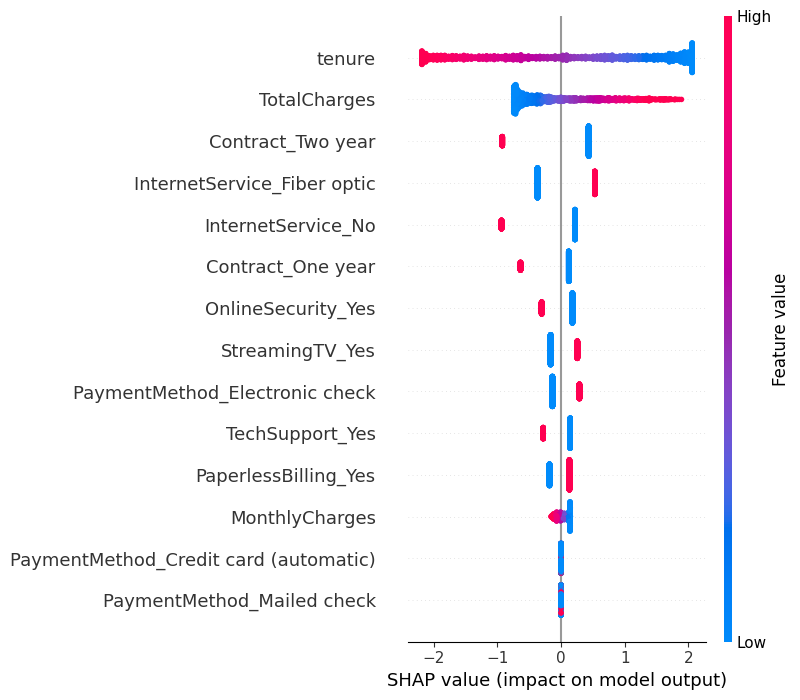

In [78]:
# Logistic Regression (Tomek Links Unweighted)
background_lr_tomek = X_train_tomek.sample(100, random_state=42).astype(float)
explainer_lr_tomek = shap.Explainer(lr_tomek_tuned, background_lr_tomek)
shap_values_lr_tomek = explainer_lr_tomek(X_test_float)

shap.summary_plot(
    shap_values_lr_tomek.values,
    X_test_float,
    feature_names=X_test.columns,
    title="SHAP — Logistic Regression (Unweighted - Tomek)"
)

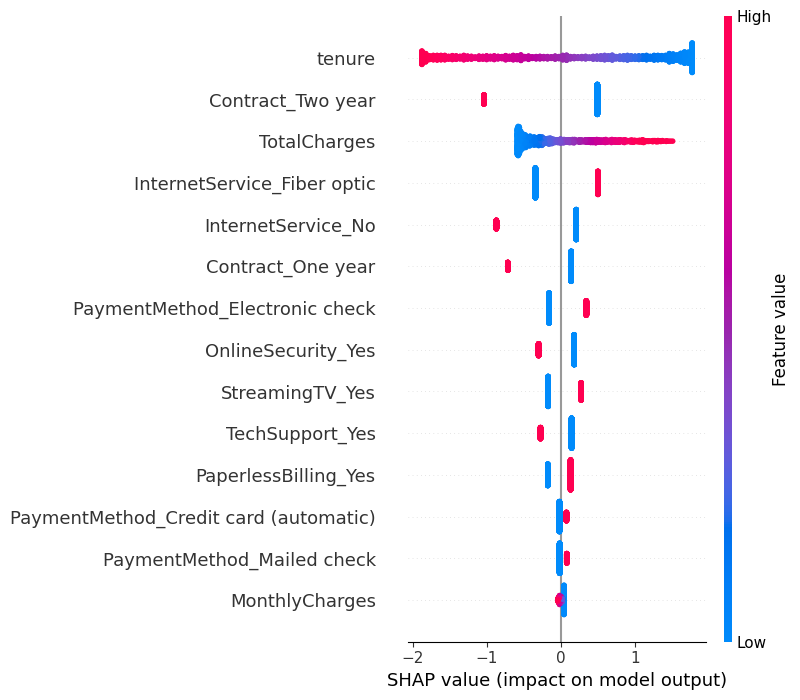

In [79]:
# Logistic Regression (Tomek Links Weighted)
background_lr_tomek_w = X_train_tomek.sample(100, random_state=42).astype(float)
explainer_lr_tomek_w = shap.Explainer(lr_tomek_w_tuned, background_lr_tomek_w)
shap_values_lr_tomek_w = explainer_lr_tomek_w(X_test_float)

shap.summary_plot(
    shap_values_lr_tomek_w.values,
    X_test_float,
    feature_names=X_test.columns,
    title="SHAP — Logistic Regression (Weighted - Tomek)"
)

 99%|===================| 2787/2814 [01:14<00:00]        

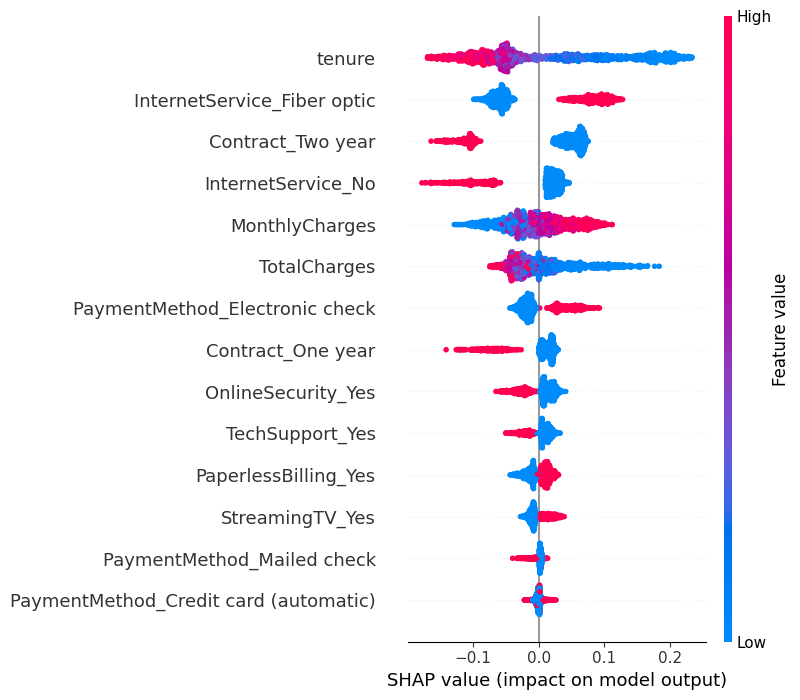

In [80]:
# Random Forest (Tomek Links Unweighted)
background_rf_tomek = X_train_tomek_float.sample(100, random_state=42)
explainer_rf_tomek = shap.Explainer(rf_tomek_tuned, background_rf_tomek)
shap_values_rf_tomek = explainer_rf_tomek(X_test_float, check_additivity=False)

shap.summary_plot(
    shap_values_rf_tomek.values[:, :, 1],  # Churn class
    X_test_float,
    feature_names=X_test.columns,
    title="SHAP — Random Forest (Unweighted - Tomek)"
)

 99%|===================| 2782/2814 [01:07<00:00]        

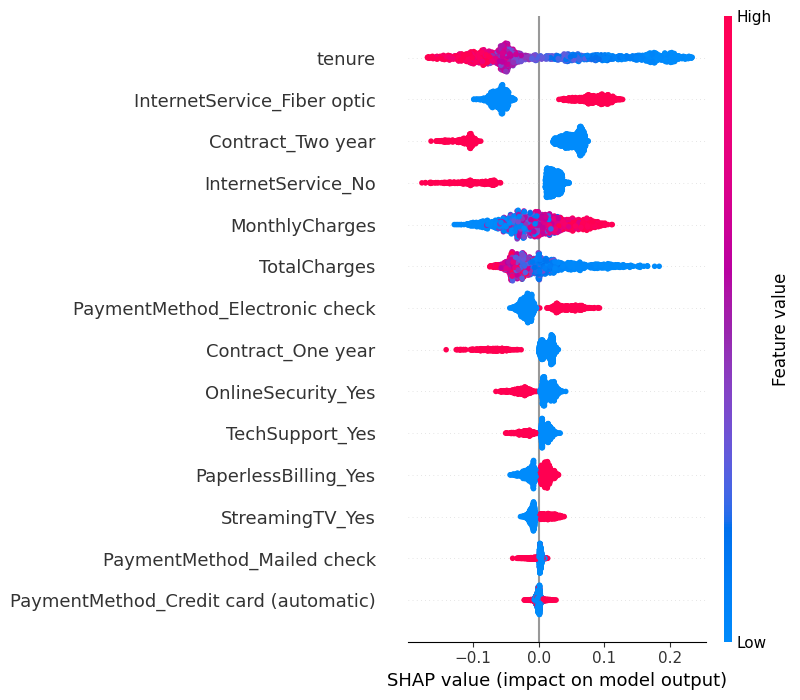

In [81]:
# Random Forest (Tomek Links Weighted)
background_rf_tomek_w = X_train_tomek_float.sample(100, random_state=42)
explainer_rf_tomek_w = shap.Explainer(rf_tomek_w_tuned, background_rf_tomek_w)
shap_values_rf_tomek_w = explainer_rf_tomek_w(X_test_float, check_additivity=False)

shap.summary_plot(
    shap_values_rf_tomek_w.values[:, :, 1],
    X_test_float,
    feature_names=X_test.columns,
    title="SHAP — Random Forest (Weighted - Tomek)"
)

## 12.0 ROC Curves

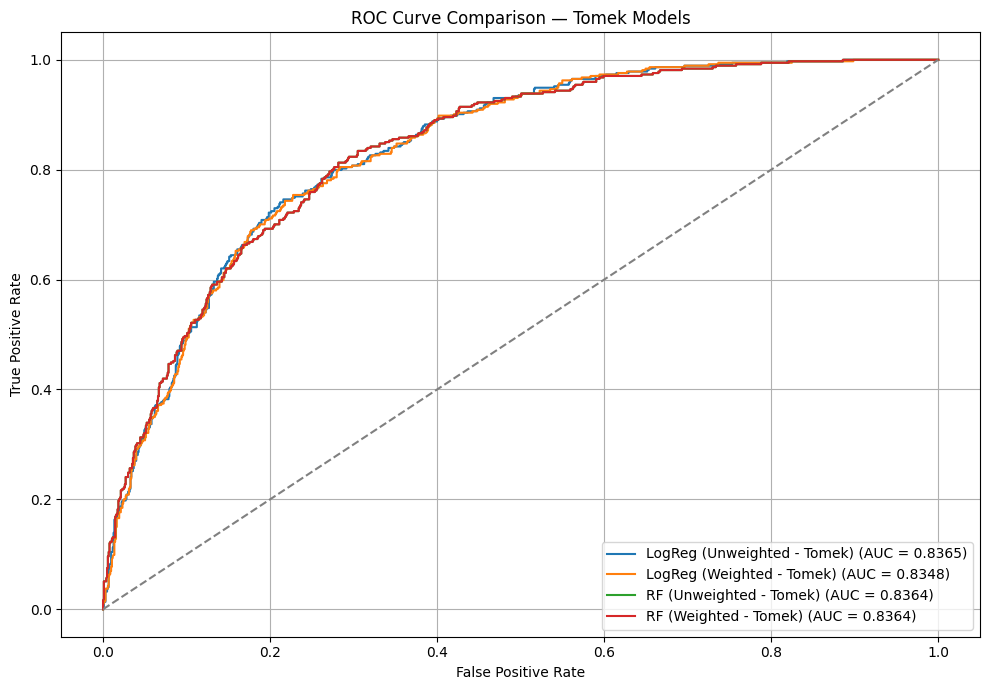

In [82]:
# Function to calculate ROC data
def get_roc_data(model, X, y, label):
    y_score = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc, label

# Prepare ROC data for the final 4 best Tomek models
roc_data = [
    get_roc_data(lr_tomek_tuned,   X_test, y_test, "LogReg (Unweighted - Tomek)"),
    get_roc_data(lr_tomek_w_tuned, X_test, y_test, "LogReg (Weighted - Tomek)"),
    get_roc_data(rf_tomek_tuned,   X_test, y_test, "RF (Unweighted - Tomek)"),
    get_roc_data(rf_tomek_w_tuned, X_test, y_test, "RF (Weighted - Tomek)")
]

# Plot ROC curves
plt.figure(figsize=(10, 7))
for fpr, tpr, roc_auc, label in roc_data:
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.4f})")

# Diagonal (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Plot settings
plt.title("ROC Curve Comparison — Tomek Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## 13.0 Cross-Validation

In [83]:
# Final models and labels
model_keys = {
    "Logistic Regression (Unweighted - Tomek)": "LR_Tomek_Unweighted",
    "Logistic Regression (Weighted - Tomek)": "LR_Tomek_Weighted",
    "Random Forest (Unweighted - Tomek)": "RF_Tomek_Unweighted",
    "Random Forest (Weighted - Tomek)": "RF_Tomek_Weighted"
}

# Get Tomek-resampled training data
X_train_tomek, y_train_tomek = resampling_sources["Tomek"]

# Loop and report
for label, key in model_keys.items():
    search = rand_search_results[key]
    model = search.best_estimator_
    
    # CV F1
    cv_f1 = search.best_score_
    
    # Train F1
    train_preds = model.predict(X_train_tomek)
    train_f1 = f1_score(y_train_tomek, train_preds)
    
    # Test F1
    test_preds = model.predict(X_test)
    test_f1 = f1_score(y_test, test_preds)

    # Print report
    print(f"{label}\n{'-' * len(label)}")
    print(f"Cross-Validation (5-fold) F1 Score: {cv_f1:.4f}")
    print(f"Train Set F1 Score           : {train_f1:.4f}")
    print(f"Test Set F1 Score            : {test_f1:.4f}")

    # Quick analysis
    gap_train_test = abs(train_f1 - test_f1)
    if gap_train_test > 0.1:
        print("Analysis:")
        print("- Significant drop from train to test ⇒ Overfitting likely\n")
    elif abs(cv_f1 - test_f1) <= 0.03:
        print("Analysis:")
        print("- Test F1 is close to CV F1 ⇒ Good generalization")
        print("- Train F1 is only slightly higher ⇒ No strong overfitting\n")
    else:
        print("Analysis:")
        print("- Acceptable generalization with mild overfitting\n")

Logistic Regression (Unweighted - Tomek)
----------------------------------------
Cross-Validation (5-fold) F1 Score: 0.6522
Train Set F1 Score           : 0.6606
Test Set F1 Score            : 0.6234
Analysis:
- Test F1 is close to CV F1 ⇒ Good generalization
- Train F1 is only slightly higher ⇒ No strong overfitting

Logistic Regression (Weighted - Tomek)
--------------------------------------
Cross-Validation (5-fold) F1 Score: 0.6740
Train Set F1 Score           : 0.6756
Test Set F1 Score            : 0.6113
Analysis:
- Acceptable generalization with mild overfitting

Random Forest (Unweighted - Tomek)
----------------------------------
Cross-Validation (5-fold) F1 Score: 0.6816
Train Set F1 Score           : 0.7415
Test Set F1 Score            : 0.6238
Analysis:
- Significant drop from train to test ⇒ Overfitting likely

Random Forest (Weighted - Tomek)
--------------------------------
Cross-Validation (5-fold) F1 Score: 0.6816
Train Set F1 Score           : 0.7415
Test Set F1 Sco